In [ ]:
import zipfile
import os

zip_file_path = 'A. Segmentation.zip'
extract_dir = './'

# Crear el directorio de extracción si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Archivo '{zip_file_path}' descomprimido en '{extract_dir}'")

Archivo 'A. Segmentation.zip' descomprimido en './'


Paso 1: Definir las rutas y configuración

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm # Para barra de progreso (pip install tqdm)
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
INTERMEDIATE_SIZE = 1024
IMG_SIZE = 256 # Nuevo tamaño de entrada del U-Net (el parche)
NUM_CLASSES = 6  # 1 Fondo + 5 Lesiones
BASE_DIR = "A. Segmentation"
SEED = 42

# Sufijos de archivo para cada lesión según IDRiD (ej: IDRiD_01_MA.tif)
LESION_SUFFIXES = {
    'MA': '_MA.tif',
    'HE': '_HE.tif',
    'EX': '_EX.tif',
    'SE': '_SE.tif',
    'OD': '_OD.tif'
}

Paso 2: Función para cargar y fusionar datos

In [ ]:
def load_idrid_data(img_dir, lesion_folders, img_size=(IMG_SIZE, IMG_SIZE)):
    X = []
    Y = []

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    print(f"Procesando {len(image_files)} imágenes desde: {img_dir.split('/')[-2]}")

    for img_name in tqdm(image_files):
        # 1. Cargar y preprocesar Imagen Original
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INTERMEDIATE_SIZE, INTERMEDIATE_SIZE))
        img = img / 255.0 # Normalizar
        X.append(img)

        file_id = os.path.splitext(img_name)[0]

        # 2. Construir la Máscara Multicanal
        lesion_masks = []
        lesion_keys = ['MA', 'HE', 'EX', 'SE', 'OD']

        for key in lesion_keys:
            mask_filename = file_id + LESION_SUFFIXES[key]
            mask_path = os.path.join(lesion_folders[key], mask_filename)

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (INTERMEDIATE_SIZE, INTERMEDIATE_SIZE), interpolation=cv2.INTER_NEAREST)
                # CORRECCIÓN: Convierte cualquier valor > 0 a 1 (arregla el problema del umbral 76)
                mask = (mask > 0).astype(np.uint8)
            else:
                # FIX: Create the zero mask with INTERMEDIATE_SIZE to match other masks
                mask = np.zeros((INTERMEDIATE_SIZE, INTERMEDIATE_SIZE), dtype=np.uint8)

            lesion_masks.append(mask)

        lesion_masks = np.array(lesion_masks)
        lesion_masks = np.moveaxis(lesion_masks, 0, -1)

        # 3. Calcular el canal de "Fondo" (Background)
        all_lesions = np.sum(lesion_masks, axis=-1)
        # 1 si no hay lesiones, 0 si sí hay
        background_mask = np.where(all_lesions == 0, 1, 0).astype(np.uint8)
        background_mask = np.expand_dims(background_mask, axis=-1)

        # 4. Concatenar: [Fondo, MA, HE, EX, SE, OD]
        final_mask = np.concatenate([background_mask, lesion_masks], axis=-1)
        Y.append(final_mask)

    return np.array(X), np.array(Y)

In [ ]:
# --- 1. CARGA DE DATOS ---

# Rutas de Entrenamiento
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/a. Training Set")
TRAIN_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/a. Training Set")
TRAIN_LESION_FOLDERS = {
    'MA': os.path.join(TRAIN_GT_DIR, "1. Microaneurysms"), 'HE': os.path.join(TRAIN_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TRAIN_GT_DIR, "3. Hard Exudates"), 'SE': os.path.join(TRAIN_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TRAIN_GT_DIR, "5. Optic Disc")
}

# Rutas de Testing (para validación)
TEST_IMG_DIR = os.path.join(BASE_DIR, "1. Original Images/b. Testing Set")
TEST_GT_DIR = os.path.join(BASE_DIR, "2. All Segmentation Groundtruths/b. Testing Set")
TEST_LESION_FOLDERS = {
    'MA': os.path.join(TEST_GT_DIR, "1. Microaneurysms"), 'HE': os.path.join(TEST_GT_DIR, "2. Haemorrhages"),
    'EX': os.path.join(TEST_GT_DIR, "3. Hard Exudates"), 'SE': os.path.join(TEST_GT_DIR, "4. Soft Exudates"),
    'OD': os.path.join(TEST_GT_DIR, "5. Optic Disc")
}


X_train, y_train = load_idrid_data(TRAIN_IMG_DIR, TRAIN_LESION_FOLDERS)
X_test, y_test = load_idrid_data(TEST_IMG_DIR, TEST_LESION_FOLDERS)

print("\n--- RESUMEN DE DATOS CARGADOS ---")
print(f"Entrenamiento: X={X_train.shape}, Y={y_train.shape}")
print(f"Testing (Validación): X={X_test.shape}, Y={y_test.shape}")

Procesando 54 imágenes desde: 1. Original Images


100%|██████████| 54/54 [00:10<00:00,  5.25it/s]


Procesando 27 imágenes desde: 1. Original Images


100%|██████████| 27/27 [00:04<00:00,  5.86it/s]



--- RESUMEN DE DATOS CARGADOS ---
Entrenamiento: X=(54, 1024, 1024, 3), Y=(54, 1024, 1024, 6)
Testing (Validación): X=(27, 1024, 1024, 3), Y=(27, 1024, 1024, 6)


# Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# --- 1. DEFINICIÓN DE FUNCIONES DE PÉRDIDA (LOSS) ---

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Métrica Dice (Asegura el casting a float32)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def weighted_combined_loss(y_true, y_pred):
    """Pérdida Combinada: Dice Loss + Weighted Categorical Crossentropy (WCCE)"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 1. Dice Loss
    dice = (1 - dice_coefficient(y_true, y_pred))

    # 2. Weighted Categorical Crossentropy (WCCE)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cce_per_pixel = - y_true * K.log(y_pred)

    # Aplicar los pesos
    weighted_cce_per_pixel = cce_per_pixel * CLASS_WEIGHTS
    wcce = K.sum(weighted_cce_per_pixel) / K.sum(y_true)

    # Ponderación final 50/50
    return 0.5 * dice + 0.5 * wcce

#------ Función Weighted Categorical Crossentropy
# Definición de Pesos (Debe estar definida en tu código principal)
# [Fondo, MA, HE, EX, SE, OD]
CLASS_WEIGHTS = tf.constant([0.01, 100.0, 50.0, 5.0, 35.0, 1.0], dtype=tf.float32)

# Las funciones dice_coefficient y dice_loss deben mantenerse como están (con el tf.cast)

def weighted_combined_loss(y_true, y_pred):
    """
    Pérdida Combinada: Dice Loss + Weighted Categorical Crossentropy (WCCE)
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 1. Dice Loss (No necesita ponderación extra, ya maneja el desbalance)
    dice = (1 - dice_coefficient(y_true, y_pred))

    # 2. Weighted Categorical Crossentropy (WCCE)

    # Calcular CCE estándar (pérdida por píxel)
    # tf.clip_by_value evita log(0)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cce_per_pixel = - y_true * K.log(y_pred) # Aplica la fórmula CCE por cada píxel

    # Multiplicar la pérdida por el tensor de pesos (broadcasting)
    # Forma de y_true: (N, H, W, 6). Forma de CLASS_WEIGHTS: (6)
    weighted_cce_per_pixel = cce_per_pixel * CLASS_WEIGHTS

    # Sumar y promediar para obtener la pérdida del lote
    wcce = K.sum(weighted_cce_per_pixel) / K.sum(y_true)

    # Ponderación final (Podemos dar 50% al Dice y 50% al WCCE)
    # Esto evita que el modelo priorice demasiado una sola parte de la función
    return 0.5 * dice + 0.5 * wcce

# --- 2. ARQUITECTURA U-NET MEJORADA (BN + DROPOUT) ---

def unet_model_regularized(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, dropout_rate=0.5):
    inputs = Input(input_size)

    def conv_block(x, filters, kernel_size=3, padding='same', kernel_initializer='he_normal'):
        c = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        c = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)
        return c

    # Encoder
    conv1 = conv_block(inputs, 64); pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128); pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256); pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512); pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024)
    conv5 = Dropout(dropout_rate)(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([conv4, up6], axis=3); merge6 = Dropout(dropout_rate)(merge6)
    conv6 = conv_block(merge6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = conv_block(merge7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = conv_block(merge8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = conv_block(merge9, 64)

    # Salida
    output = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

Datos en Alta Resolución

In [ ]:
print(f"Entrenamiento: X={X_train.shape}, Y={y_train.shape}")
print(f"Testing (Validación): X={X_test.shape}, Y={y_test.shape}")

Entrenamiento: X=(54, 1024, 1024, 3), Y=(54, 1024, 1024, 6)
Testing (Validación): X=(27, 1024, 1024, 3), Y=(27, 1024, 1024, 6)


PASO 1: Mapeo de Coordenadas y Generador (Código Maestro)

In [ ]:
import numpy as np
from tqdm import tqdm

# --- 1. MAPEO DE COORDENADAS ---
def get_lesion_coordinates(Y_data):
    """
    Genera un diccionario donde key=idx_imagen y value=lista de coordenadas (y,x)
    de píxeles que contienen CUALQUIER lesión (canales 1 a 5).
    """
    lesion_coords = {}
    N = Y_data.shape[0]

    print("Escaneando imágenes para encontrar lesiones...")
    for idx in tqdm(range(N)):
        # Sumamos canales 1-5 (MA, HE, EX, SE, OD). Ignoramos Fondo (0).
        # Nota: Y_data debe ser (N, H, W, 6)
        mask_lesions = np.sum(Y_data[idx, :, :, 1:], axis=-1)

        # Obtener coordenadas donde hay algo (valor > 0)
        ys, xs = np.where(mask_lesions > 0)

        # Si la imagen tiene lesiones, guardamos las coordenadas
        if len(ys) > 0:
            # Guardamos como lista de pares (y, x)
            coords = np.column_stack((ys, xs))
            lesion_coords[idx] = coords

    print(f"✅ Se encontraron lesiones en {len(lesion_coords)} de {N} imágenes.")
    return lesion_coords

# --- 2. GENERADOR ENFOCADO (HARD NEGATIVE MINING) ---
def lesion_aware_patch_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.7):
    """
    Genera parches.
    - 70% del tiempo: Centra el parche en una lesión real.
    - 30% del tiempo: Parche aleatorio (para aprender fondo).
    """
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]

    # Pre-calcular límites para no salirnos de la imagen
    max_y = H - patch_size
    max_x = W - patch_size

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Elegir imagen aleatoria
            idx = np.random.randint(0, N)

            # Decidir estrategia: ¿Enfocado o Aleatorio?
            # Solo podemos enfocar si la imagen 'idx' tiene lesiones registradas
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                # --- ESTRATEGIA ENFOCADA ---
                # 1. Obtener todas las coordenadas de lesión de esta imagen
                coords = lesion_coords[idx]

                # 2. Elegir un punto de lesión al azar
                target_y, target_x = coords[np.random.randint(len(coords))]

                # 3. Calcular esquina superior izquierda para que 'target' quede en el centro aprox
                # Aleatorizamos un poco el centro para que no sea siempre el píxel exacto del medio
                y_start = target_y - np.random.randint(patch_size // 4, patch_size * 3 // 4)
                x_start = target_x - np.random.randint(patch_size // 4, patch_size * 3 // 4)

            else:
                # --- ESTRATEGIA ALEATORIA (FONDO) ---
                y_start = np.random.randint(0, max_y)
                x_start = np.random.randint(0, max_x)

            # --- CLIPPING (Seguridad) ---
            # Asegurar que las coordenadas estén dentro de la imagen válida
            y_start = np.clip(y_start, 0, max_y)
            x_start = np.clip(x_start, 0, max_x)

            # --- EXTRACCIÓN ---
            batch_x[i] = X_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]
            batch_y[i] = Y_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]

        yield (batch_x, batch_y)

PASO 2: Ejecución de Mapeo e Instanciación

In [ ]:
# 1. Generar mapas de coordenadas (Tarda unos segundos)
print("--- Mapeando Entrenamiento ---")
coords_train = get_lesion_coordinates(y_train)

print("--- Mapeando Testing ---")
coords_test = get_lesion_coordinates(y_test)

# 2. Crear los generadores
PATCH_SIZE = 256
BATCH_SIZE = 4 # O 8 si tienes buena GPU

train_gen_focused = lesion_aware_patch_generator(
    X_train, y_train, coords_train, BATCH_SIZE, PATCH_SIZE, focus_ratio=0.70
)

val_gen_focused = lesion_aware_patch_generator(
    X_test, y_test, coords_test, BATCH_SIZE, PATCH_SIZE, focus_ratio=0.50 # 50% en validación para balancear
)

--- Mapeando Entrenamiento ---
Escaneando imágenes para encontrar lesiones...


100%|██████████| 54/54 [00:01<00:00, 33.48it/s]


✅ Se encontraron lesiones en 54 de 54 imágenes.
--- Mapeando Testing ---
Escaneando imágenes para encontrar lesiones...


100%|██████████| 27/27 [00:00<00:00, 34.14it/s]

✅ Se encontraron lesiones en 27 de 27 imágenes.


El Plan de Emergencia (La Bala de Plata)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- 1. NUEVOS PESOS NORMALIZADOS ---
# Mantenemos la jerarquía pero reducimos la magnitud para evitar inestabilidad
# [Fondo, MA, HE, EX, SE, OD]
# Fondo bajo, MA alto, pero la suma total no es gigantesca
CLASS_WEIGHTS = tf.constant([0.1, 10.0, 5.0, 2.0, 5.0, 1.0], dtype=tf.float32)

def stable_weighted_loss(y_true, y_pred):
    """Weighted Cross Entropy estable + Dice"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 1. Dice Loss (Estándar)
    dice = 1 - dice_coefficient(y_true, y_pred)

    # 2. Weighted Cross Entropy
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    # Fórmula estándar de CCE
    cce = -y_true * K.log(y_pred)
    # Aplicar pesos
    weighted_cce = cce * CLASS_WEIGHTS
    # Promediar
    loss_cce = K.sum(weighted_cce) / K.sum(y_true)

    return 0.5 * dice + 0.5 * loss_cce

In [ ]:
# --- 2. REINICIO RÁPIDO ---
K.clear_session()
model = unet_model_regularized(input_size=(PATCH_SIZE, PATCH_SIZE, 3), num_classes=6, dropout_rate=0.5)

model.compile(
    optimizer=Adam(learning_rate=1e-4), # LR Estándar (más rápido)
    loss=stable_weighted_loss,
    metrics=['accuracy', dice_coefficient]
)

# --- 3. ENTRENAMIENTO CORTO PERO EFECTIVO ---
callbacks = [
    ModelCheckpoint('unet_final_attempt.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    # Paciencia reducida, si no aprende en 15 épocas, no aprenderá.
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print("🚀 INICIANDO PLAN DE EMERGENCIA: Pesos Normalizados + Parches Enfocados")
history = model.fit(
    train_gen_focused,
    validation_data=val_gen_focused,
    steps_per_epoch=1000 // BATCH_SIZE, # 250 pasos
    validation_steps=200 // BATCH_SIZE,  # 50 pasos
    epochs=60, # Menos épocas, debería converger antes
    callbacks=callbacks,
    verbose=1
)

🚀 INICIANDO PLAN DE EMERGENCIA: Pesos Normalizados + Parches Enfocados
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6955 - dice_coefficient: 0.4463 - loss: 0.4880
Epoch 1: val_loss improved from inf to 0.40224, saving model to unet_final_attempt.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 354ms/step - accuracy: 0.6959 - dice_coefficient: 0.4468 - loss: 0.4877 - val_accuracy: 0.8731 - val_dice_coefficient: 0.6649 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8808 - dice_coefficient: 0.6850 - loss: 0.3347
Epoch 2: val_loss improved from 0.40224 to 0.32561, saving model to unet_final_attempt.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - accuracy: 0.8808 - dice_coefficient: 0.6851 - loss: 0.3346 - val_accuracy: 0.9198 - val_dice_coefficient: 0.7696 - val_loss: 0.3256 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8914 - dice_coefficient: 0.7480 - lo

# **Testing**
Paso 1: Cargar el Mejor Modelo y Preparar Datos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. CARGAR EL MEJOR MODELO
# Usa el nombre del archivo que definiste en tu último entrenamiento
checkpoint_path = '/content/vgg16_512_v11.keras' # O 'unet_thesis_tversky.keras'

try:
    model.load_weights(checkpoint_path)
    print(f"✅ Pesos cargados exitosamente desde: {checkpoint_path}")
except:
    print("⚠️ No se encontró el checkpoint. Usando los pesos actuales de la memoria.")

# 2. PREPARAR EL GENERADOR DE TEST (Evaluación Completa)
# Usamos focus_ratio=0.5 para que la evaluación sea balanceada entre zonas sanas y enfermas
test_gen_full = lesion_aware_patch_generator(
    X_test, y_test, coords_test,
    batch_size=4, patch_size=256, focus_ratio=0.5
)

# Calculamos cuántos pasos se necesitan para recorrer todo el dataset de prueba varias veces
# Esto asegura resultados estadísticamente sólidos
STEPS_EVAL = (len(X_test) * 20) // 4

✅ Pesos cargados exitosamente desde: /content/vgg16_512_v11.keras


Paso 2: Generador de Reporte Clínico (Métricas)

In [ ]:
def generate_clinical_report(model, generator, steps):
    print(f"🏥 Generando Reporte Clínico (Evaluando {steps} lotes)...")

    # Acumuladores para TP, FP, FN por clase
    # Shape: (6 clases)
    total_tp = np.zeros(6)
    total_fp = np.zeros(6)
    total_fn = np.zeros(6)

    class_names = ['Fondo', 'Microaneurismas (MA)', 'Hemorragias (HE)',
                   'Exudados Duros (EX)', 'Exudados Blandos (SE)', 'Disco Óptico (OD)']

    for _ in tqdm(range(steps)):
        X_batch, y_true_batch = next(generator)

        # Predicción
        y_pred_prob = model.predict(X_batch, verbose=0)
        y_pred_classes = np.argmax(y_pred_prob, axis=-1)
        y_true_classes = np.argmax(y_true_batch, axis=-1)

        # Calcular métricas por lote para cada clase
        for i in range(6):
            true_mask = (y_true_classes == i)
            pred_mask = (y_pred_classes == i)

            # True Positives: Estaba en REAL y el modelo dijo PRED
            tp = np.sum(true_mask & pred_mask)
            # False Positives: No estaba en REAL pero el modelo dijo PRED (Falsa Alarma)
            fp = np.sum((~true_mask) & pred_mask)
            # False Negatives: Estaba en REAL pero el modelo lo ignoró (Paciente perdido)
            fn = np.sum(true_mask & (~pred_mask))

            total_tp[i] += tp
            total_fp[i] += fp
            total_fn[i] += fn

    # --- CÁLCULO FINAL DE MÉTRICAS ---
    results = []
    for i in range(6):
        tp = total_tp[i]
        fp = total_fp[i]
        fn = total_fn[i]

        # Dice Score: 2TP / (2TP + FP + FN)
        dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)

        # Sensibilidad (Recall): TP / (TP + FN) -> ¿Cuántas lesiones reales encontré?
        sensitivity = tp / (tp + fn + 1e-6)

        # Precisión (Precision): TP / (TP + FP) -> ¿De lo que encontré, cuánto era real?
        precision = tp / (tp + fp + 1e-6)

        results.append({
            "Clase": class_names[i],
            "Dice Score": round(dice, 4),
            "Sensibilidad (Recall)": round(sensitivity, 4),
            "Precisión": round(precision, 4)
        })

    # Crear DataFrame bonito
    df_results = pd.DataFrame(results)
    return df_results

Reporte Clínico

In [ ]:
# --- EJECUTAR ---
df_metrics = generate_clinical_report(model, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES PARA LA TESIS ---")
display(df_metrics)

In [ ]:


import tensorflow as tf
import random

# --- 1. GENERADOR CON AUMENTO DE DATOS ---
# Agregamos rotaciones, espejos y cambios de brillo sobre la marcha

def augmented_patch_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.6):
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]
    max_y = H - patch_size
    max_x = W - patch_size

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Selección de imagen y coordenadas (Igual que antes)
            idx = np.random.randint(0, N)
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                coords = lesion_coords[idx]
                target_y, target_x = coords[np.random.randint(len(coords))]
                y_start = target_y - np.random.randint(patch_size // 4, patch_size * 3 // 4)
                x_start = target_x - np.random.randint(patch_size // 4, patch_size * 3 // 4)
            else:
                y_start = np.random.randint(0, max_y)
                x_start = np.random.randint(0, max_x)

            y_start = np.clip(y_start, 0, max_y)
            x_start = np.clip(x_start, 0, max_x)

            # Extraer parche base
            img_patch = X_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]
            mask_patch = Y_data[idx, y_start : y_start+patch_size, x_start : x_start+patch_size, :]

            # --- AUMENTO DE DATOS ALEATORIO ---
            # 1. Flip Horizontal
            if random.random() > 0.5:
                img_patch = np.fliplr(img_patch)
                mask_patch = np.fliplr(mask_patch)

            # 2. Flip Vertical
            if random.random() > 0.5:
                img_patch = np.flipud(img_patch)
                mask_patch = np.flipud(mask_patch)

            # 3. Rotación (0, 90, 180, 270)
            k = random.randint(0, 3)
            if k > 0:
                img_patch = np.rot90(img_patch, k)
                mask_patch = np.rot90(mask_patch, k)

            # 4. Brillo / Contraste (Solo a la imagen, no a la máscara)
            # Hacemos esto con funciones de TF o numpy simple
            if random.random() > 0.5:
                # Factor aleatorio entre 0.8 y 1.2
                factor = 0.8 + random.random() * 0.4
                img_patch = img_patch * factor
                img_patch = np.clip(img_patch, 0, 1)

            batch_x[i] = img_patch
            batch_y[i] = mask_patch

        yield (batch_x, batch_y)

In [ ]:
# --- 2. FOCAL TVERSKY LOSS ---
# Alpha: Penalización por Falsos Positivos (Queremos subir esto para mejorar Precisión)
# Beta: Penalización por Falsos Negativos (Recall)
# Gamma: Focal parameter (enfocarse en ejemplos difíciles)

def tversky(y_true, y_pred, alpha=0.7): # Alpha alto = Priorizar Precisión (Reducir FP)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + K.epsilon()) / (true_pos + alpha * false_pos + (1 - alpha) * false_neg + K.epsilon())

def focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculamos Tversky para cada clase y sumamos (excluyendo fondo si se desea, o ponderando)
    # Aquí aplicamos globalmente o por canales. Aplicaremos por canales.

    pt_1 = tversky(y_true[..., 1:], y_pred[..., 1:], alpha=alpha) # Lesiones
    return K.pow((1 - pt_1), gamma)

# Versión compatible con Keras compile
def focal_tversky_loss(y_true, y_pred):
    return focal_tversky(y_true, y_pred, alpha=0.7, gamma=1.33)

In [ ]:
# --- 3. RE-ENTRENAMIENTO MEJORADO ---

# Crear generadores aumentados
# CORRECCIÓN: 'batch_size' debe ir en minúsculas
train_gen_aug = augmented_patch_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256, focus_ratio=0.6
)

# Reiniciar modelo
K.clear_session()
model_v2 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.4)

model_v2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_tversky_loss, # Usamos la nueva Loss
    metrics=['accuracy', dice_coefficient]
)

callbacks_v2 = [
    ModelCheckpoint('unet_focal_tversky.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

print("🚀 INICIANDO ENTRENAMIENTO V2: Data Augmentation + Focal Tversky Loss")
history_v2 = model_v2.fit(
    train_gen_aug,
    validation_data=val_gen_focused, # Validación sin augmentation (queremos medir realidad)
    steps_per_epoch=250,
    validation_steps=50,
    epochs=50,
    callbacks=callbacks_v2,
    verbose=1
)

🚀 INICIANDO ENTRENAMIENTO V2: Data Augmentation + Focal Tversky Loss
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6466 - dice_coefficient: 0.5290 - loss: 0.7147
Epoch 1: val_loss improved from inf to 0.63088, saving model to unet_focal_tversky.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 353ms/step - accuracy: 0.6471 - dice_coefficient: 0.5296 - loss: 0.7143 - val_accuracy: 0.8591 - val_dice_coefficient: 0.7765 - val_loss: 0.6309 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8969 - dice_coefficient: 0.8618 - loss: 0.4299
Epoch 2: val_loss improved from 0.63088 to 0.49208, saving model to unet_focal_tversky.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - accuracy: 0.8969 - dice_coefficient: 0.8619 - loss: 0.4297 - val_accuracy: 0.9168 - val_dice_coefficient: 0.8945 - val_loss: 0.4921 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9179 - dice_coefficient: 0.9042 - loss

In [ ]:
# --- EJECUTAR ---
df_metrics_v2 = generate_clinical_report(model_v2, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES PARA LA TESIS model_v2 ---")
display(df_metrics_v2)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:22<00:00,  5.90it/s]


--- RESULTADOS FINALES PARA LA TESIS model_v2 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9752                 0.9962     0.9552
1   Microaneurismas (MA)      0.0000                 0.0000     0.0000
2       Hemorragias (HE)      0.0000                 0.0000     0.0000
3    Exudados Duros (EX)      0.4704                 0.3151     0.9278
4  Exudados Blandos (SE)      0.0000                 0.0000     0.0000
5      Disco Óptico (OD)      0.9402                 0.9489     0.9317

In [ ]:
def visualize_best_examples(model, generator, num_examples=3):
    print("📸 Buscando ejemplos con lesiones visibles...")

    count = 0
    while count < num_examples:
        X_batch, y_true_batch = next(generator)

        # Predecir
        y_pred_prob = model.predict(X_batch, verbose=0)

        # Iterar sobre el lote
        for i in range(len(X_batch)):
            img = X_batch[i]
            true_mask = y_true_batch[i]
            pred_prob = y_pred_prob[i]

            # Verificar si este parche tiene Microaneurismas (Canal 1) o Hemorragias (Canal 2)
            has_ma = np.sum(true_mask[:,:,1]) > 0
            has_he = np.sum(true_mask[:,:,2]) > 0

            if has_ma or has_he:
                # ¡Encontramos uno interesante! Visualizarlo.
                print(f"\n--- Ejemplo {count + 1} (Contiene MA: {has_ma}, HE: {has_he}) ---")

                plt.figure(figsize=(12, 4))

                # Original
                plt.subplot(1, 4, 1)
                plt.imshow(img)
                plt.title("Parche Original")
                plt.axis('off')

                # MA Real vs Pred
                plt.subplot(1, 4, 2)
                plt.imshow(true_mask[:,:,1], cmap='gray')
                plt.title("REAL: Microaneurismas")
                plt.axis('off')

                plt.subplot(1, 4, 3)
                plt.imshow(pred_prob[:,:,1], cmap='jet', vmin=0, vmax=1)
                plt.title("PRED: MA (Calor)")
                plt.axis('off')

                # HE Real vs Pred
                plt.subplot(1, 4, 4)
                plt.imshow(pred_prob[:,:,2], cmap='jet', vmin=0, vmax=1)
                plt.title("PRED: Hemorragias")
                plt.axis('off')

                plt.show()

                count += 1
                if count >= num_examples:
                    return

📸 Buscando ejemplos con lesiones visibles...

--- Ejemplo 1 (Contiene MA: True, HE: True) ---


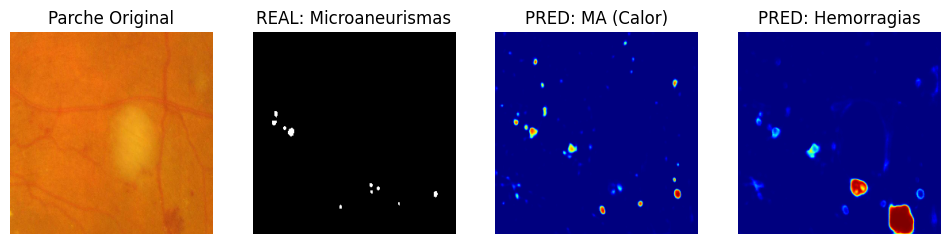


--- Ejemplo 2 (Contiene MA: True, HE: True) ---


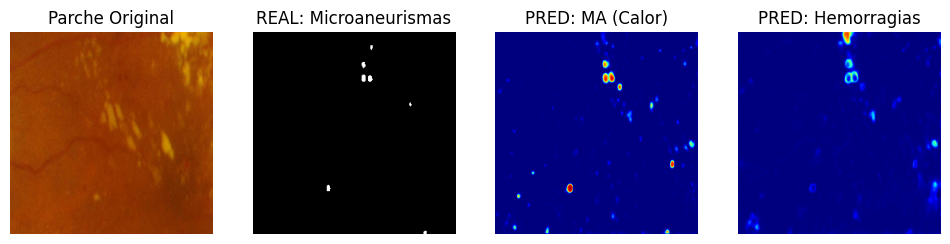


--- Ejemplo 3 (Contiene MA: True, HE: True) ---


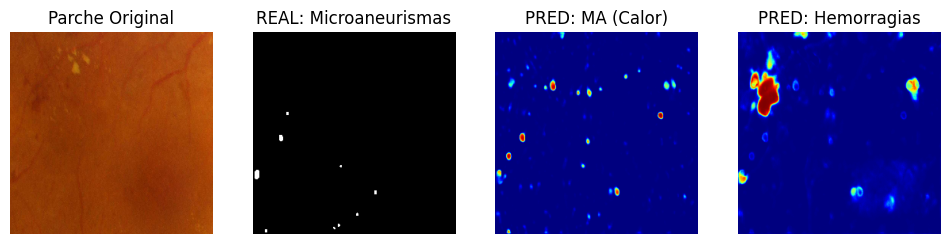


--- Ejemplo 4 (Contiene MA: True, HE: True) ---


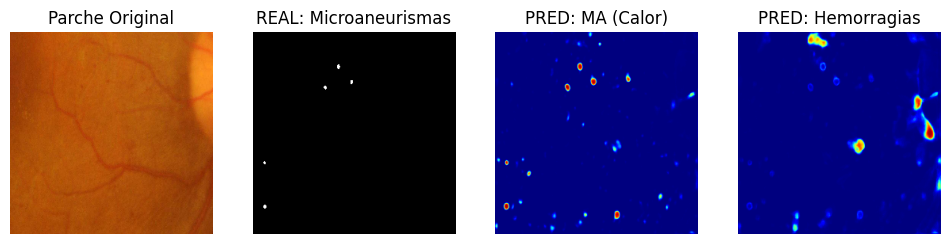


--- Ejemplo 5 (Contiene MA: True, HE: True) ---


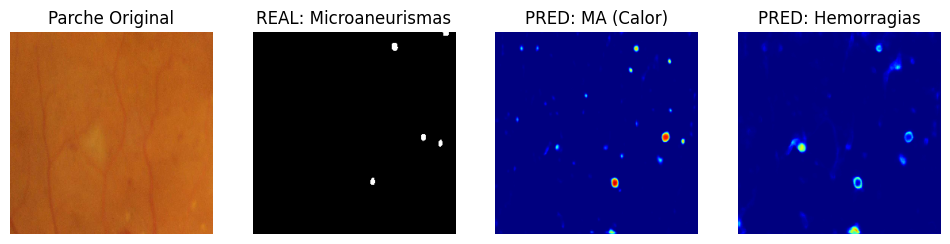

In [ ]:
# Buscar ejemplos visualmente impactantes para la tesis
# Esto buscará parches que tengan MA y HE para mostrarlos
visualize_best_examples(model, test_gen_full, num_examples=5)

📸 Buscando ejemplos con lesiones visibles...

--- Ejemplo 1 (Contiene MA: True, HE: True) ---


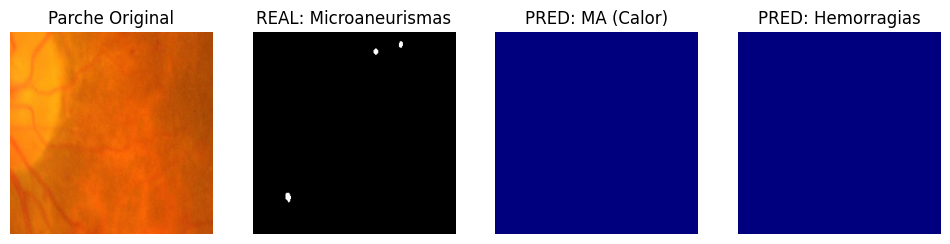


--- Ejemplo 2 (Contiene MA: True, HE: True) ---


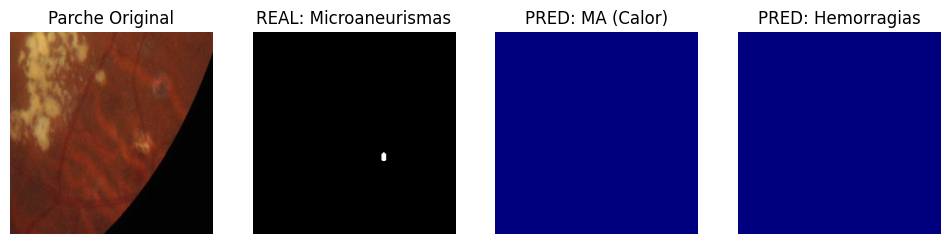


--- Ejemplo 3 (Contiene MA: True, HE: True) ---


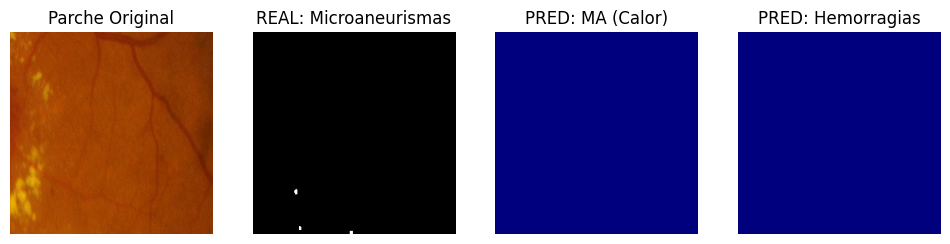


--- Ejemplo 4 (Contiene MA: True, HE: True) ---


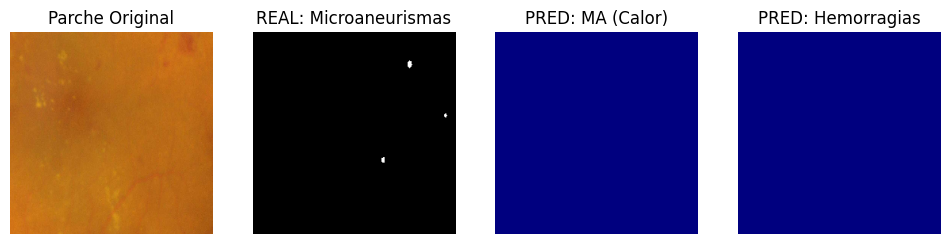


--- Ejemplo 5 (Contiene MA: True, HE: True) ---


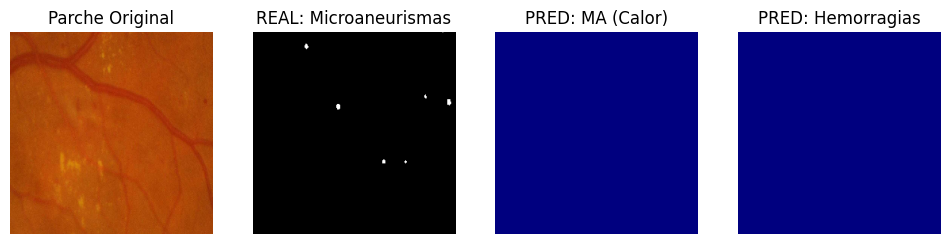

In [ ]:
# Buscar ejemplos visualmente impactantes para la tesis
# Esto buscará parches que tengan MA y HE para mostrarlos
visualize_best_examples(model_v2, test_gen_full, num_examples=5)

Nivel Matemático: Las Curvas de Aprendizaje

---



In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Usamos los nombres de métricas correctos de la compilación
    acc = history.history['dice_coefficient']
    val_acc = history.history['val_dice_coefficient']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Gráfica de Dice (Precisión de Segmentación)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Dice')
    plt.plot(epochs, val_acc, 'r', label='Validation Dice')
    plt.title('Dice Coefficient (Métrica de Segmentación)')
    plt.legend()

    # Gráfica de Loss (Pérdida Ponderada)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Weighted Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Weighted Loss')
    plt.title('Weighted Combined Loss (Pérdida Ponderada)')
    plt.legend()

    plt.show()

In [ ]:
plot_history(history)

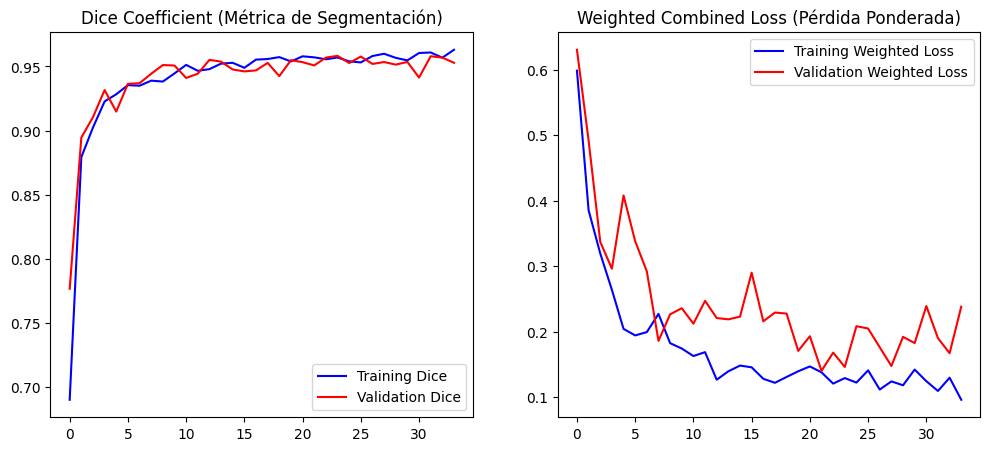

In [ ]:
plot_history(history_v2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_full_segmentation(model, generator, num_samples=1):
    """
    Visualiza la segmentación final completa (todas las clases en una imagen).
    Compara la imagen original, el mapa de segmentación real (Ground Truth)
    y el mapa de segmentación predicho por el modelo.
    """

    # Definir colores distintos para cada clase (Formato RGBA)
    # Usamos una paleta de alto contraste
    colors = np.array([
        [0, 0, 0, 255],       # 0: Fondo (Negro)
        [255, 0, 0, 255],     # 1: MA (Rojo brillante)
        [0, 255, 0, 255],     # 2: HE (Verde brillante)
        [0, 0, 255, 255],     # 3: EX (Azul brillante)
        [255, 255, 0, 255],   # 4: SE (Amarillo)
        [0, 255, 255, 255]    # 5: OD (Cyan)
    ], dtype=np.uint8)

    class_names = ['Fondo', 'Micro (MA)', 'Hemo (HE)', 'Hard Ex (EX)', 'Soft Ex (SE)', 'Optic Disc (OD)']

    print(f"Visualizando {num_samples} ejemplos de segmentación completa...")

    for i in range(num_samples):
        # Obtener un lote
        X_batch, y_true_batch = next(generator)
        img = X_batch[0]
        mask_true = y_true_batch[0]

        # Predicción
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

        # --- NÚCLEO DE LA VISUALIZACIÓN ---
        # Convertir de One-Hot (6 canales) a Mapa de Índices (1 canal con valores 0-5)
        seg_true_idx = np.argmax(mask_true, axis=-1)
        seg_pred_idx = np.argmax(pred_prob, axis=-1)

        # Convertir índices a imágenes RGB usando la paleta de colores
        seg_true_rgb = colors[seg_true_idx]
        seg_pred_rgb = colors[seg_pred_idx]

        # --- GRAFICAR ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. Imagen Original
        axes[0].imshow(img)
        axes[0].set_title("Imagen Original")
        axes[0].axis('off')

        # 2. Ground Truth (Coloreado)
        axes[1].imshow(seg_true_rgb)
        axes[1].set_title("Real (Ground Truth)")
        axes[1].axis('off')

        # 3. Predicción (Coloreado)
        axes[2].imshow(seg_pred_rgb)
        axes[2].set_title("Predicción del Modelo")
        axes[2].axis('off')

        # Crear leyenda personalizada
        patches = [mpatches.Patch(color=colors[c]/255.0, label=class_names[c]) for c in range(6)]
        fig.legend(handles=patches, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

        plt.tight_layout()
        plt.show()

# --- CÓMO EJECUTARLA ---
# Usa el generador de test completo para buscar ejemplos variados
visualize_full_segmentation(model, test_gen_full, num_samples=30)

# Código para Visualización de Imágenes Completas
Definición de Colores y Función de Carga de Ground Truth

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os

# --- CONFIGURACIÓN DE COLORES ---
# Paleta para 6 clases (Formato RGB)
COLORS = np.array([
    [0, 0, 0],       # 0: Fondo (Negro)
    [255, 0, 0],     # 1: MA (Rojo)
    [0, 255, 0],     # 2: HE (Verde)
    [0, 0, 255],     # 3: EX (Azul)
    [255, 255, 0],   # 4: SE (Amarillo)
    [0, 255, 255]    # 5: OD (Cyan)
], dtype=np.uint8)

CLASS_NAMES = ['Fondo', 'Micro (MA)', 'Hemo (HE)', 'Hard Ex (EX)', 'Soft Ex (SE)', 'Optic Disc (OD)']
PATCH_SIZE = 256

# --- FUNCIÓN AUXILIAR 1: Cargar GT Completo ---
def load_full_gt_categorical(file_id, lesion_folders, img_shape):
    """
    Carga las 5 máscaras binarias y las combina en una sola imagen
    donde el valor del píxel es la clase (0-5).
    Maneja superposiciones dando prioridad.
    """
    h, w = img_shape[:2]
    # Inicializar imagen con Fondo (clase 0)
    gt_categorical = np.zeros((h, w), dtype=np.uint8)

    # Orden de prioridad para pintar (de menor a mayor prioridad).
    # Lo que se pinta al final queda encima.
    # Prioridad: OD > SE > EX > HE > MA
    lesion_order_priority = ['MA', 'HE', 'EX', 'SE', 'OD']

    for i, key in enumerate(lesion_order_priority, start=1):
        mask_filename = file_id + LESION_SUFFIXES[key]
        mask_path = os.path.join(lesion_folders[key], mask_filename)

        if os.path.exists(mask_path):
            # Cargar en gris, redimensionar al tamaño original y binarizar
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype(np.uint8)

            # Donde la máscara es 1, asignamos el índice de la clase 'i'
            # np.where reemplaza solo donde la condición es True
            gt_categorical = np.where(mask == 1, i, gt_categorical)

    return gt_categorical

Ejecutar la Visualización

In [ ]:
def debug_full_image_simple(model, img_id, test_img_dir, test_lesion_folders):
    print(f"--- DEBUGGING {img_id} ---")

    # 1. Cargar imagen
    path = os.path.join(test_img_dir, img_id + '.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. REDIMENSIONAR A LO BRUTO (Para probar si la red entiende la imagen global)
    # Usamos 512x512 o 1024x1024, algo que sea cuadrado como el entrenamiento
    debug_size = (1024, 1024)
    img_resized = cv2.resize(img, debug_size)

    # 3. Normalizar
    img_input = img_resized.astype(np.float32) / 255.0

    # 4. Predecir de golpe (Sin parches)
    # Nota: U-Net es "Fully Convolutional", puede aceptar tamaños distintos a 256
    # si la VRAM aguanta. 1024 suele aguantar.
    pred_prob = model.predict(np.expand_dims(img_input, axis=0))[0]
    pred_idx = np.argmax(pred_prob, axis=-1)

    # 5. Cargar GT y redimensionar igual
    gt_categorical = load_full_gt_categorical(img_id, test_lesion_folders, img.shape)
    gt_resized = cv2.resize(gt_categorical, debug_size, interpolation=cv2.INTER_NEAREST)

    # 6. Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_resized); ax[0].set_title("Input Resized")
    ax[1].imshow(COLORS[gt_resized]); ax[1].set_title("GT Resized")
    ax[2].imshow(COLORS[pred_idx]); ax[2].set_title("Prediction (Directa)")
    plt.show()

# PRUEBA ESTO CON UNA IMAGEN
debug_full_image_simple(model, 'IDRiD_55', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_77', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_81', TEST_IMG_DIR, TEST_LESION_FOLDERS)

# Task
Define an **aggressive weighted loss** function (e.g., `aggressive_weighted_loss`) with significantly higher class weights for Microaneurysms (MA) and Haemorrhages (HE) (e.g., weights around 100-200) to force the model to detect these small lesions.

Then, initialize a new model instance, **`model_v3`**, and train it using the existing `augmented_patch_generator` and this new aggressive loss function. Finally, evaluate `model_v3` using `generate_clinical_report` to verify if the sensitivity for MA and HE has improved from zero.

## Define Aggressive Weighted Loss

### Subtask:
Define a new loss function with aggressive weights for Microaneurysms and Haemorrhages.


**Reasoning**:
Define the aggressive weighted loss function as requested, specifically targeting Microaneurysms and Haemorrhages with high weights.



In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# --- 1. DEFINICIÓN DE PESOS AGRESIVOS ---
# [Fondo, MA, HE, EX, SE, OD]
# Penalización extrema para obligar a detectar MA (200.0) y HE (100.0)
AGGRESSIVE_CLASS_WEIGHTS = tf.constant([0.01, 200.0, 100.0, 10.0, 10.0, 1.0], dtype=tf.float32)

def aggressive_weighted_loss(y_true, y_pred):
    """
    Pérdida agresiva que combina Dice Loss con Weighted Crossentropy
    usando pesos muy altos para lesiones pequeñas.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 1. Dice Loss (1 - Dice Coefficient)
    # Reutilizamos la función dice_coefficient definida anteriormente
    dice = 1 - dice_coefficient(y_true, y_pred)

    # 2. Weighted Categorical Crossentropy (WCCE)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # CCE estándar pixel-wise
    cce_per_pixel = - y_true * K.log(y_pred)

    # Aplicar los pesos agresivos (Broadcasting)
    weighted_cce_per_pixel = cce_per_pixel * AGGRESSIVE_CLASS_WEIGHTS

    # Promediar la pérdida ponderada
    wcce = K.sum(weighted_cce_per_pixel) / K.sum(y_true)

    # Retornar combinación equilibrada
    return 0.5 * dice + 0.5 * wcce

**Reasoning**:
Initialize model_v3, compile it with the newly defined aggressive_weighted_loss, and train it using the augmented patch generator. This targets the task of verifying if higher weights improve sensitivity for small lesions.



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- 1. REINICIO Y MODELO V3 ---
K.clear_session()
model_v3 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.4)

# Compilar con la nueva Loss Agresiva
model_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=aggressive_weighted_loss,
    metrics=['accuracy', dice_coefficient]
)

# --- 2. GENERADORES ---
# Re-instanciamos para asegurar (Batch size 4)
train_gen_v3 = augmented_patch_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256, focus_ratio=0.6
)

# --- 3. CALLBACKS ---
callbacks_v3 = [
    ModelCheckpoint('unet_aggressive.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

# --- 4. ENTRENAMIENTO ---
print("🚀 INICIANDO ENTRENAMIENTO V3: Loss Agresiva (MA/HE Weights)")
history_v3 = model_v3.fit(
    train_gen_v3,
    validation_data=val_gen_focused,
    steps_per_epoch=250,  # 1000 parches por época
    validation_steps=50,
    epochs=50,
    callbacks=callbacks_v3,
    verbose=1
)

🚀 INICIANDO ENTRENAMIENTO V3: Loss Agresiva (MA/HE Weights)
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1421 - dice_coefficient: 0.1838 - loss: 1.3877
Epoch 1: val_loss improved from inf to 2.06794, saving model to unet_aggressive.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 356ms/step - accuracy: 0.1421 - dice_coefficient: 0.1838 - loss: 1.3870 - val_accuracy: 0.3176 - val_dice_coefficient: 0.2646 - val_loss: 2.0679 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2392 - dice_coefficient: 0.2263 - loss: 0.9918
Epoch 2: val_loss improved from 2.06794 to 1.33063, saving model to unet_aggressive.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - accuracy: 0.2393 - dice_coefficient: 0.2264 - loss: 0.9918 - val_accuracy: 0.4233 - val_dice_coefficient: 0.3301 - val_loss: 1.3306 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3235 - dice_coefficient: 0.2741 - loss: 0.9899
Epoch 

In [ ]:
# --- EJECUTAR ---
df_metrics_v3 = generate_clinical_report(model_v3, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES PARA LA TESIS model_v3 ---")
display(df_metrics_v3)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:25<00:00,  5.39it/s]


--- RESULTADOS FINALES PARA LA TESIS model_v3 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.8750                 0.7811     0.9946
1   Microaneurismas (MA)      0.0874                 0.7704     0.0463
2       Hemorragias (HE)      0.2008                 0.8849     0.1133
3    Exudados Duros (EX)      0.5919                 0.8023     0.4690
4  Exudados Blandos (SE)      0.4666                 0.5456     0.4075
5      Disco Óptico (OD)      0.8394                 0.9718     0.7387

Plot modelo v3

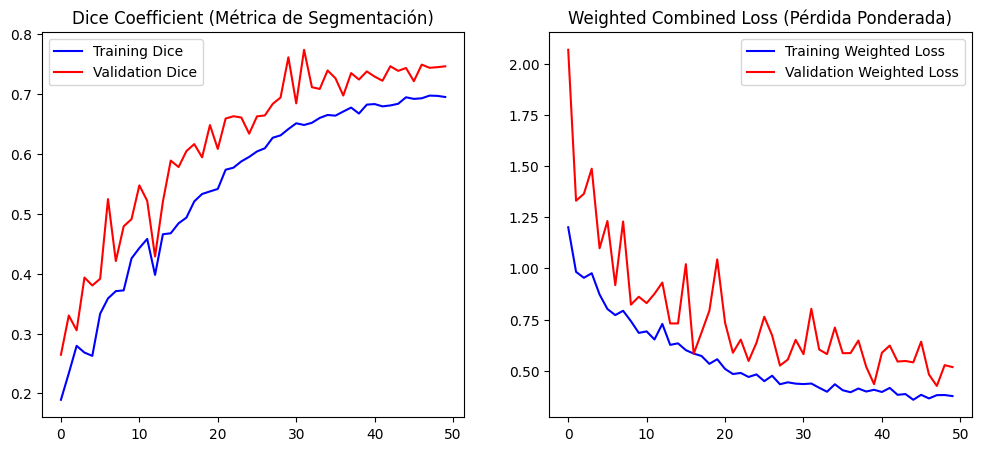

In [ ]:
plot_history(history_v3)

In [ ]:
# --- ESTRATEGIA V4: PESOS BALANCEADOS (REDUCCIÓN DE RUIDO) ---

# Ajustamos los pesos para mantener la detección pero reducir falsos positivos
# [Fondo, MA, HE, EX, SE, OD]
# Subimos Fondo (0.2) para limpiar ruido.
# Bajamos MA (50) y HE (30) para que no sean tan dominantes.
BALANCED_WEIGHTS = tf.constant([0.2, 50.0, 30.0, 10.0, 10.0, 1.0], dtype=tf.float32)

def balanced_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # 1. Dice Loss (Ayuda con la forma)
    dice = 1 - dice_coefficient(y_true, y_pred)

    # 2. Weighted Cross Entropy (Ayuda con la detección)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cce = -y_true * K.log(y_pred)
    weighted_cce = cce * BALANCED_WEIGHTS
    loss_cce = K.sum(weighted_cce) / K.sum(y_true)

    # 3. Focal Loss Simplificada (Opcional, pero WCCE suele bastar aquí)
    # Nos quedamos con la combinación simple que ya sabemos que converge
    return 0.5 * dice + 0.5 * loss_cce

# --- REINICIO Y ENTRENAMIENTO MODELO V4 ---
K.clear_session()
model_v4 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5)

model_v4.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=balanced_weighted_loss,
    metrics=['accuracy', dice_coefficient]
)

callbacks_v4 = [
    ModelCheckpoint('unet_balanced.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V4: Estrategia Balanceada")
history_v4 = model_v4.fit(
    train_gen_v3, # Usamos el mismo generador aumentado
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=60,
    callbacks=callbacks_v4,
    verbose=1
)


🚀 INICIANDO ENTRENAMIENTO V4: Estrategia Balanceada
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3508 - dice_coefficient: 0.2693 - loss: 1.0871
Epoch 1: val_loss improved from inf to 1.26195, saving model to unet_balanced.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 381ms/step - accuracy: 0.3513 - dice_coefficient: 0.2695 - loss: 1.0866 - val_accuracy: 0.7988 - val_dice_coefficient: 0.4098 - val_loss: 1.2619 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6019 - dice_coefficient: 0.4186 - loss: 0.8188
Epoch 2: val_loss improved from 1.26195 to 1.04808, saving model to unet_balanced.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 381ms/step - accuracy: 0.6020 - dice_coefficient: 0.4187 - loss: 0.8187 - val_accuracy: 0.7135 - val_dice_coefficient: 0.5640 - val_loss: 1.0481 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6647 - dice_coefficient: 0.5061 - loss: 0.7110
Epoch 3: val_loss

In [ ]:
# --- EVALUAR MODELO V4 ---
df_metrics_v4 = generate_clinical_report(model_v4, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V4 (BALANCEADO) ---")
display(df_metrics_v4)

# Comparar visualmente V3 (Ruidoso) vs V4 (Balanceado)
print("\n--- Comparación de Métricas: V3 (Agresivo) vs V4 (Balanceado) ---")
cols = ["Clase", "Sensibilidad (Recall)", "Precisión", "Dice Score"]
print("Modelo V3:")
display(df_metrics_v3[cols])
print("Modelo V4:")
display(df_metrics_v4[cols])

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:24<00:00,  5.59it/s]


--- RESULTADOS FINALES: MODELO V4 (BALANCEADO) ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9631                 0.9348     0.9931
1   Microaneurismas (MA)      0.1967                 0.7295     0.1137
2       Hemorragias (HE)      0.4322                 0.8099     0.2947
3    Exudados Duros (EX)      0.6566                 0.8429     0.5377
4  Exudados Blandos (SE)      0.6136                 0.7037     0.5440
5      Disco Óptico (OD)      0.9420                 0.9823     0.9049


--- Comparación de Métricas: V3 (Agresivo) vs V4 (Balanceado) ---
Modelo V3:


Clase  Sensibilidad (Recall)  Precisión  Dice Score
0                  Fondo                 0.7811     0.9946      0.8750
1   Microaneurismas (MA)                 0.7704     0.0463      0.0874
2       Hemorragias (HE)                 0.8849     0.1133      0.2008
3    Exudados Duros (EX)                 0.8023     0.4690      0.5919
4  Exudados Blandos (SE)                 0.5456     0.4075      0.4666
5      Disco Óptico (OD)                 0.9718     0.7387      0.8394

Modelo V4:


Clase  Sensibilidad (Recall)  Precisión  Dice Score
0                  Fondo                 0.9348     0.9931      0.9631
1   Microaneurismas (MA)                 0.7295     0.1137      0.1967
2       Hemorragias (HE)                 0.8099     0.2947      0.4322
3    Exudados Duros (EX)                 0.8429     0.5377      0.6566
4  Exudados Blandos (SE)                 0.7037     0.5440      0.6136
5      Disco Óptico (OD)                 0.9823     0.9049      0.9420

MODELO V5

In [ ]:
# --- REINICIO Y ENTRENAMIENTO MODELO V5 ---
K.clear_session()
model_v5 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5)

model_v5.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=stable_weighted_loss,
    metrics=['accuracy', dice_coefficient]
)

train_gen_v5 = augmented_patch_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256, focus_ratio=0.6
)


callbacks_v5 = [
    ModelCheckpoint('unet_balanced_v5.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V5")
history_v5 = model_v5.fit(
    train_gen_v5, # Usamos el mismo generador aumentado
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=60,
    callbacks=callbacks_v5,
    verbose=1
)


🚀 INICIANDO ENTRENAMIENTO V5: Estrategia Balanceada
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6518 - dice_coefficient: 0.4443 - loss: 0.5030
Epoch 1: val_loss improved from inf to 0.37148, saving model to unet_balanced_v5.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 330ms/step - accuracy: 0.6522 - dice_coefficient: 0.4447 - loss: 0.5027 - val_accuracy: 0.9129 - val_dice_coefficient: 0.6476 - val_loss: 0.3715 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8531 - dice_coefficient: 0.6807 - loss: 0.3306
Epoch 2: val_loss did not improve from 0.37148
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 309ms/step - accuracy: 0.8531 - dice_coefficient: 0.6808 - loss: 0.3305 - val_accuracy: 0.7987 - val_dice_coefficient: 0.7073 - val_loss: 0.3918 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8678 - dice_coefficient: 0.7387 - loss: 0.3157
Epoch 3: val_loss improved from 0.37148 to 0.27360, sav

In [ ]:
# --- EVALUAR MODELO V5 ---
df_metrics_v5 = generate_clinical_report(model_v5, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V5 ---")
display(df_metrics_v5)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:22<00:00,  6.11it/s]


--- RESULTADOS FINALES: MODELO V5 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9780                 0.9663     0.9900
1   Microaneurismas (MA)      0.3187                 0.6034     0.2165
2       Hemorragias (HE)      0.6100                 0.7511     0.5136
3    Exudados Duros (EX)      0.7561                 0.8187     0.7023
4  Exudados Blandos (SE)      0.5854                 0.7309     0.4882
5      Disco Óptico (OD)      0.9552                 0.9878     0.9248

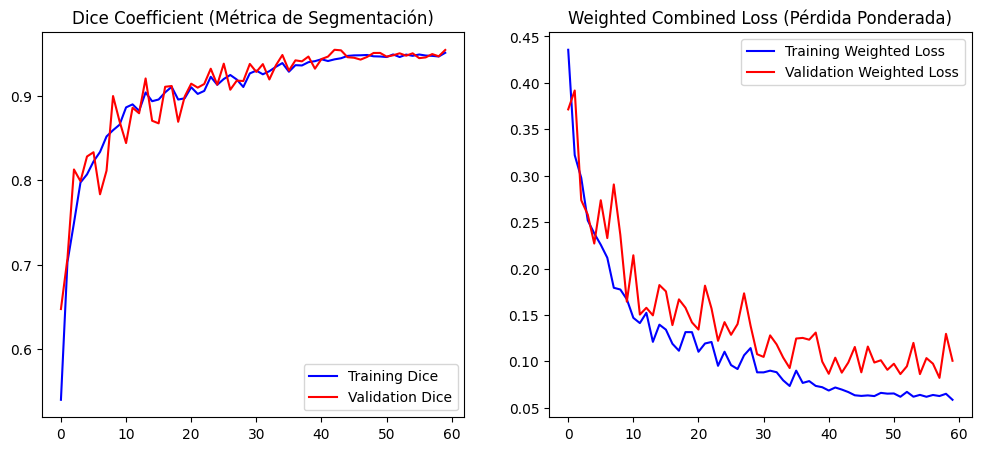

In [ ]:
plot_history(history_v5)

Modelo v6

In [ ]:
1 [Fondo, MA, HE, EX, SE, OD]
# Fondo sube de 0.1 a 0.5 para filtrar ruido.
# MA baja de 10.0 a 6.0 para mejorar la precisión.
CLASS_WEIGHTS = tf.constant([0.5, 6.0, 4.0, 2.0, 4.0, 1.0], dtype=tf.float32)


def stable_weighted_loss_v6(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # 1. Dice Loss (Métrica de solapamiento)
    dice = 1.0 - dice_coefficient(y_true, y_pred)

    # 2. Weighted Cross Entropy (Normalizada)
    # Multiplicamos por pesos ANTES del promedio para balancear clases
    weighted_cce = -tf.reduce_sum(y_true * K.log(y_pred) * CLASS_WEIGHTS, axis=-1)
    loss_cce = tf.reduce_mean(weighted_cce)

    # Combinación 50/50
    return 0.5 * dice + 0.5 * loss_cce


In [ ]:
# --- REINICIO Y ENTRENAMIENTO MODELO V5 ---
K.clear_session()
model_v6 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5)

model_v6.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=stable_weighted_loss_v6,
    metrics=['accuracy', dice_coefficient]
)

train_gen_v6 = augmented_patch_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256, focus_ratio=0.6
)


callbacks_v6 = [
    ModelCheckpoint('unet_balanced_v6.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V6")
history_v6 = model_v6.fit(
    train_gen_v6, # Usamos el mismo generador aumentado
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=60,
    callbacks=callbacks_v6,
    verbose=1
)


🚀 INICIANDO ENTRENAMIENTO V5
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5943 - dice_coefficient: 0.3889 - loss: 0.7654
Epoch 1: val_loss improved from inf to 0.54246, saving model to unet_balanced_v6.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 326ms/step - accuracy: 0.5951 - dice_coefficient: 0.3895 - loss: 0.7647 - val_accuracy: 0.8956 - val_dice_coefficient: 0.5748 - val_loss: 0.5425 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8996 - dice_coefficient: 0.6933 - loss: 0.4254
Epoch 2: val_loss did not improve from 0.54246
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 310ms/step - accuracy: 0.8996 - dice_coefficient: 0.6934 - loss: 0.4253 - val_accuracy: 0.8718 - val_dice_coefficient: 0.7096 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9099 - dice_coefficient: 0.7680 - loss: 0.3468
Epoch 3: val_loss improved from 0.54246 to 0.36264, saving model to unet_balan

In [ ]:
# --- EVALUAR MODELO V6 ---
df_metrics_v6 = generate_clinical_report(model_v6, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V6 ---")
display(df_metrics_v6)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:22<00:00,  6.12it/s]


--- RESULTADOS FINALES: MODELO V6 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9811                 0.9797     0.9825
1   Microaneurismas (MA)      0.3486                 0.3369     0.3612
2       Hemorragias (HE)      0.5493                 0.5383     0.5607
3    Exudados Duros (EX)      0.6732                 0.6253     0.7291
4  Exudados Blandos (SE)      0.3990                 0.5212     0.3233
5      Disco Óptico (OD)      0.9410                 0.9739     0.9103

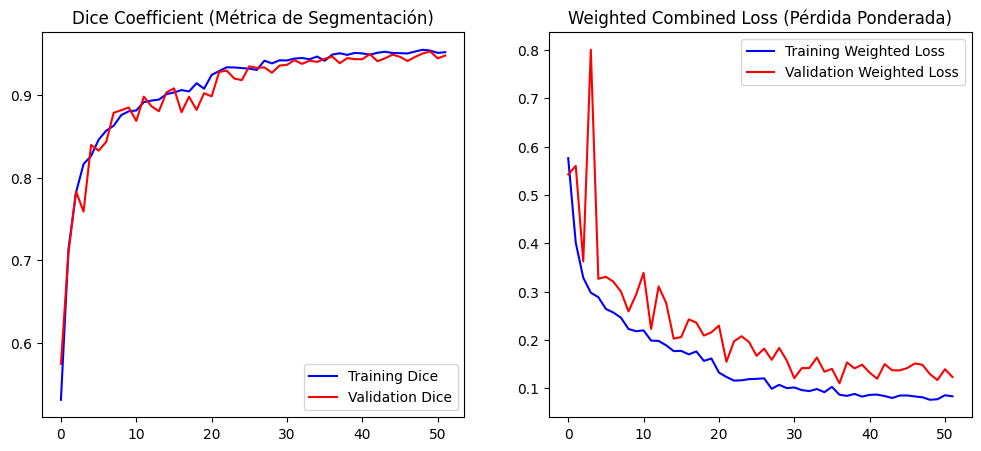

In [ ]:
plot_history(history_v6)

# Modelo v7

In [ ]:
# --- REINICIO Y ENTRENAMIENTO MODELO V5 ---
K.clear_session()
model_v7 = unet_model_regularized(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5)

model_v7.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=stable_weighted_loss_v6,
    metrics=['accuracy', dice_coefficient]
)

train_gen_v7 = augmented_patch_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256, focus_ratio=0.6
)


callbacks_v7 = [
    ModelCheckpoint('unet_balanced_v7.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    # Patience sube a 20 para evitar paradas prematuras
    EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True),
    # Patience sube a 8, min_lr evita que se congele el aprendizaje
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1, min_lr=1e-5)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V7")
history_v7 = model_v7.fit(
    train_gen_v7, # Usamos el mismo generador aumentado
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=60,
    callbacks=callbacks_v7,
    verbose=1
)


🚀 INICIANDO ENTRENAMIENTO V7
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6402 - dice_coefficient: 0.3582 - loss: 0.7828
Epoch 1: val_loss improved from inf to 0.56565, saving model to unet_balanced_v7.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 326ms/step - accuracy: 0.6409 - dice_coefficient: 0.3587 - loss: 0.7822 - val_accuracy: 0.9119 - val_dice_coefficient: 0.5425 - val_loss: 0.5657 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9047 - dice_coefficient: 0.6313 - loss: 0.4519
Epoch 2: val_loss improved from 0.56565 to 0.40230, saving model to unet_balanced_v7.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.9047 - dice_coefficient: 0.6315 - loss: 0.4518 - val_accuracy: 0.9282 - val_dice_coefficient: 0.7195 - val_loss: 0.4023 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9140 - dice_coefficient: 0.7367 - loss: 0.3629
Epoch 3: val_loss improved from 0.

In [ ]:
# --- EVALUAR MODELO V7 ---
df_metrics_v7 = generate_clinical_report(model_v7, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V7 ---")
display(df_metrics_v7)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:22<00:00,  6.01it/s]


--- RESULTADOS FINALES: MODELO V7 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9830                 0.9850     0.9809
1   Microaneurismas (MA)      0.3876                 0.3999     0.3761
2       Hemorragias (HE)      0.5800                 0.4986     0.6933
3    Exudados Duros (EX)      0.7710                 0.7717     0.7703
4  Exudados Blandos (SE)      0.5705                 0.5208     0.6306
5      Disco Óptico (OD)      0.9537                 0.9621     0.9454

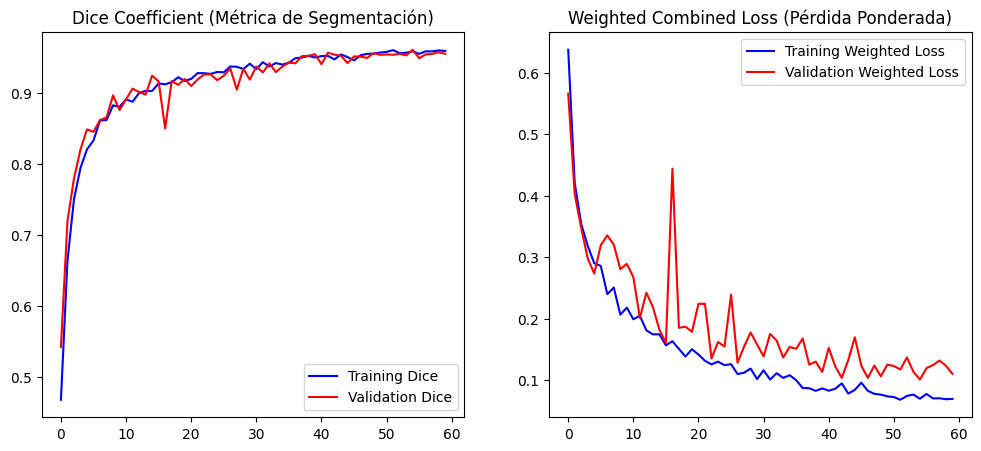

In [ ]:
plot_history(history_v7)

Función de Predicción con TTA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_with_tta(model, image_array):
    """
    Inferencia robusta promediando 3 vistas: Original, Flip Horizontal, Flip Vertical.
    """
    # Asegurar que la imagen tiene la forma correcta (1, 256, 256, 3)
    img = np.expand_dims(image_array, axis=0)

    # 1. Predicción Original
    pred_orig = model.predict(img, verbose=0)

    # 2. Predicción Flip Horizontal (Izquierda-Derecha)
    img_lr = np.fliplr(img)
    pred_lr = model.predict(img_lr, verbose=0)
    pred_lr = np.fliplr(pred_lr) # Invertimos para alinear

    # 3. Predicción Flip Vertical (Arriba-Abajo)
    img_ud = np.flipud(img)
    pred_ud = model.predict(img_ud, verbose=0)
    pred_ud = np.flipud(pred_ud) # Invertimos

    # --- PROMEDIO FINAL ---
    # Promediamos las probabilidades softmax
    pred_final = (pred_orig + pred_lr + pred_ud) / 3.0

    return pred_final[0] # Retorna (256, 256, 6)

Prueba Visual: "La Prueba de Fuego"

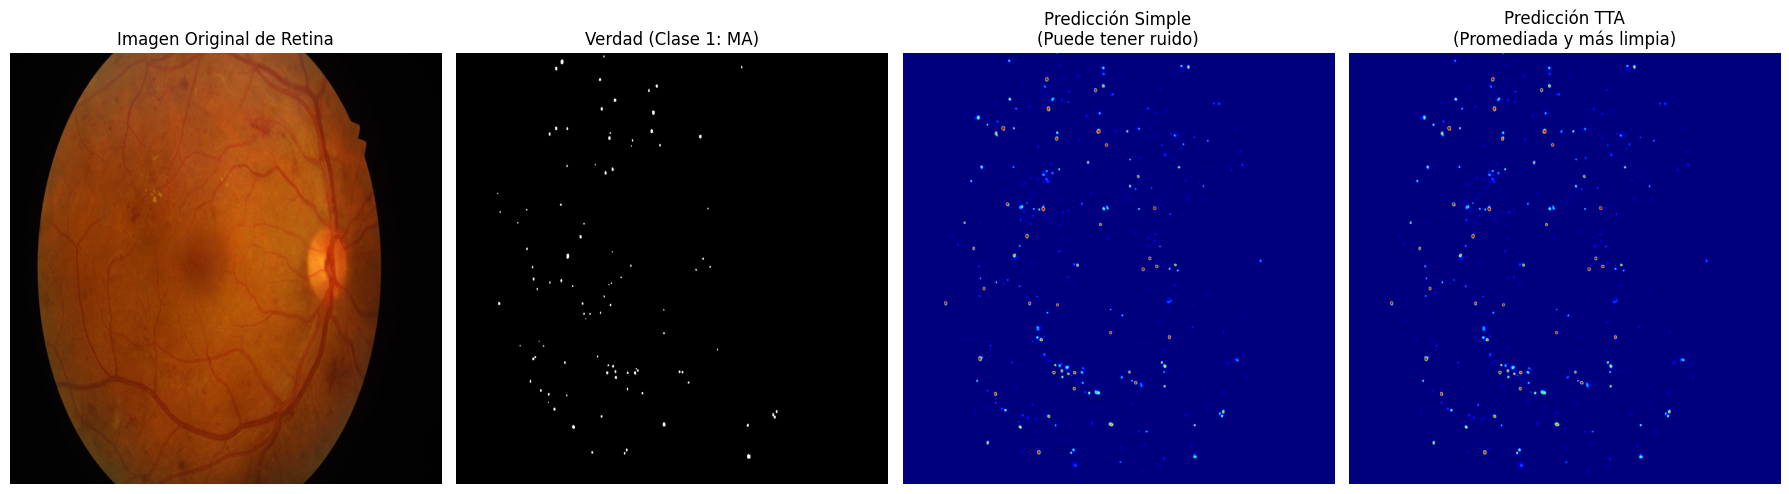

In [ ]:
# --- CONFIGURACIÓN ---
idx_prueba = 20 # Cambia esto para ver diferentes fotos
clase_interes = 1 # 1 = Microaneurismas (MA)

# Obtener datos
img_test = X_test[idx_prueba]  # Asumiendo que X_val es tu set de validación
mask_true = y_test[idx_prueba]

# 1. Predicción Estándar (Una sola pasada)
pred_single = model_v7.predict(np.expand_dims(img_test, axis=0), verbose=0)[0]

# 2. Predicción TTA (Triple pasada)
pred_tta = predict_with_tta(model_v7, img_test)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(18, 6))

# A. Imagen Original
plt.subplot(1, 4, 1)
plt.imshow(img_test)
plt.title("Imagen Original de Retina")
plt.axis('off')

# B. Ground Truth (Realidad)
plt.subplot(1, 4, 2)
plt.imshow(mask_true[:, :, clase_interes], cmap='gray')
plt.title(f"Verdad (Clase {clase_interes}: MA)")
plt.axis('off')

# C. Predicción Normal (Sin TTA)
plt.subplot(1, 4, 3)
plt.imshow(pred_single[:, :, clase_interes], cmap='jet', vmin=0, vmax=1)
plt.title("Predicción Simple\n(Puede tener ruido)")
plt.axis('off')

# D. Predicción TTA
plt.subplot(1, 4, 4)
plt.imshow(pred_tta[:, :, clase_interes], cmap='jet', vmin=0, vmax=1)
plt.title("Predicción TTA\n(Promediada y más limpia)")
plt.axis('off')

plt.tight_layout()
plt.show()



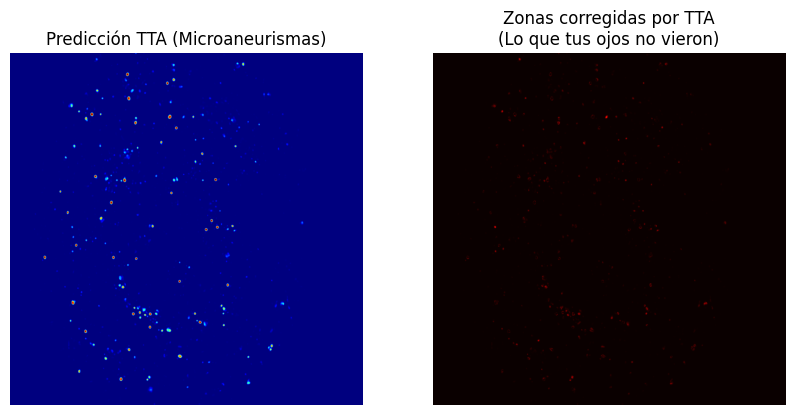

Cambio promedio de probabilidad por píxel: 0.000436


In [ ]:
# Calcular la diferencia absoluta entre la predicción simple y TTA
diff = np.abs(pred_single[:, :, 1] - pred_tta[:, :, 1])

plt.figure(figsize=(10, 5))

# 1. TTA (Tu imagen columna 4)
plt.subplot(1, 2, 1)
plt.imshow(pred_tta[:, :, 1], cmap='jet', vmin=0, vmax=1)
plt.title("Predicción TTA (Microaneurismas)")
plt.axis('off')

# 2. Diferencia (Amplificada x10 para verla)
plt.subplot(1, 2, 2)
plt.imshow(diff, cmap='hot', vmin=0, vmax=0.5) # vmax bajo para resaltar cambios sutiles
plt.title("Zonas corregidas por TTA\n(Lo que tus ojos no vieron)")
plt.axis('off')

plt.show()

print(f"Cambio promedio de probabilidad por píxel: {np.mean(diff):.6f}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Listas para métricas globales
dice_scores_tta = []
precisions_tta = []
recalls_tta = []

print("⏳ Evaluando Set de Validación con TTA (esto tomará un momento)...")

# Recorremos todo el set de validación
for i in range(len(X_test)):
    # 1. Imagen y Máscara Real
    img = X_test[i]
    mask_true = y_test[i] # Shape (256, 256, 6)

    # 2. Predicción con TTA
    pred_prob = predict_with_tta(model_v7, img)

    # 3. Binarizar (Threshold 0.5)
    pred_mask = (pred_prob > 0.5).astype(np.float32)

    # 4. Calcular Dice por imagen (solo para MA - clase 1, por ejemplo, o promedio)
    # Aquí calculamos Dice vectorizado para las 6 clases a la vez
    intersection = np.sum(mask_true * pred_mask, axis=(0, 1))
    union = np.sum(mask_true, axis=(0, 1)) + np.sum(pred_mask, axis=(0, 1))
    dice = (2. * intersection + 1e-7) / (union + 1e-7)

    # Guardamos métricas crudas para promediar después
    dice_scores_tta.append(dice)

    # Imprimir progreso cada 50 imágenes
    if i % 50 == 0:
        print(f"Procesada {i}/{len(X_test)}")

# --- GENERAR REPORTE FINAL ---
dice_scores_tta = np.array(dice_scores_tta) # Shape (N_muestras, 6)
mean_dice = np.mean(dice_scores_tta, axis=0)

clases = ["Fondo", "MA (Microaneurismas)", "HE (Hemorragias)",
          "EX (Exudados Duros)", "SE (Exudados Blandos)", "OD (Disco Óptico)"]

results_df = pd.DataFrame({
    "Clase": clases,
    "Dice Score (con TTA)": mean_dice
})

print("\n=== RESULTADOS FINALES CON TTA ===")
print(results_df)

⏳ Evaluando Set de Validación con TTA (esto tomará un momento)...
Procesada 0/27

=== RESULTADOS FINALES CON TTA ===
                   Clase  Dice Score (con TTA)
0                  Fondo              0.990818
1   MA (Microaneurismas)              0.399587
2       HE (Hemorragias)              0.509886
3    EX (Exudados Duros)              0.664733
4  SE (Exudados Blandos)              0.531892
5      OD (Disco Óptico)              0.948612


# Modelo V8 (Attention U-Net)

1. Código del Modelo V8: Attention U-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout, Multiply, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# --- BLOQUE DE ATENCIÓN (La novedad para tu Tesis) ---
def attention_gate(x, g, inter_channels):
    """
    Filtra las características de 'x' (skip connection) usando la señal 'g' (decoder).
    x: Feature map del encoder (Skip Connection) -> Alta resolución, mucho ruido.
    g: Feature map del decoder (Gating Signal) -> Baja resolución, contexto semántico.
    inter_channels: Canales intermedios para la operación.
    """
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # 1. Alineación de señales (Convolución 1x1 para igualar canales)
    # Theta: Procesa x
    theta_x = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    # Phi: Procesa g
    phi_g = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)

    # 2. Suma y Activación (Mecanismo de Atención Aditiva)
    # Al sumar, la red aprende dónde coinciden las características relevantes
    f = Add()([theta_x, phi_g])
    f = Activation('relu')(f)

    # 3. Cálculo de Coeficientes de Atención (Sigmoide: 0 a 1)
    # Psi: Colapsa a 1 canal para crear el mapa de calor de atención
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = Activation('sigmoid')(psi_f)

    # 4. Filtrado (Multiplicación elemento a elemento)
    # Las zonas irrelevantes (fondo) se multiplican por ~0 y desaparecen.
    # Las lesiones se multiplican por ~1 y se mantienen.
    att_x = Multiply()([x, rate])

    return att_x

# --- ARQUITECTURA PRINCIPAL ---
def attention_unet_model(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5):
    inputs = Input(input_size)

    # Función auxiliar para bloques convolucionales (Igual que V7)
    def conv_block(x, filters):
        c = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        c = BatchNormalization()(c); c = Activation('relu')(c)
        c = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(c)
        c = BatchNormalization()(c); c = Activation('relu')(c)
        return c

    # --- ENCODER (Bajada) ---
    c1 = conv_block(inputs, 64); p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128); p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256); p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512); p4 = MaxPooling2D((2, 2))(c4)

    # --- BOTTLENECK ---
    c5 = conv_block(p4, 1024)
    c5 = Dropout(dropout_rate)(c5)

    # --- DECODER CON ATENCIÓN (Subida) ---

    # Bloque 6
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(512, 2, padding='same', activation='relu')(u6)
    # APLICAMOS ATENCIÓN: Filtramos c4 usando u6 antes de concatenar
    att6 = attention_gate(x=c4, g=u6, inter_channels=256)
    m6 = concatenate([att6, u6], axis=3)
    m6 = Dropout(dropout_rate)(m6)
    c6 = conv_block(m6, 512)

    # Bloque 7
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(256, 2, padding='same', activation='relu')(u7)
    # Atención: Filtramos c3 usando u7
    att7 = attention_gate(x=c3, g=u7, inter_channels=128)
    m7 = concatenate([att7, u7], axis=3)
    c7 = conv_block(m7, 256)

    # Bloque 8
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, 2, padding='same', activation='relu')(u8)
    # Atención: Filtramos c2 usando u8
    att8 = attention_gate(x=c2, g=u8, inter_channels=64)
    m8 = concatenate([att8, u8], axis=3)
    c8 = conv_block(m8, 128)

    # Bloque 9
    u9 = UpSampling2D((2, 2))(c9 := c8) # Nota: c8 es la entrada
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, 2, padding='same', activation='relu')(u9)
    # Atención: Filtramos c1 usando u9
    att9 = attention_gate(x=c1, g=u9, inter_channels=32)
    m9 = concatenate([att9, u9], axis=3)
    c9 = conv_block(m9, 64)

    # SALIDA
    outputs = Conv2D(num_classes, 1, activation='softmax')(c9)

    return Model(inputs=inputs, outputs=outputs, name="Attention_UNet_V8")

Cómo Entrenar la V8 (Estrategia de Tesis)

In [ ]:
# --- ENTRENAMIENTO MODELO V8 (ATTENTION U-NET) ---
K.clear_session()

# Instanciamos el nuevo modelo con atención
model_v8 = attention_unet_model(input_size=(256, 256, 3), num_classes=6, dropout_rate=0.5)

# Usamos la MISMA configuración que V7 para una comparación justa
model_v8.compile(
    optimizer=Adam(learning_rate=1e-4), # Mismo LR inicial
    loss=stable_weighted_loss_v6,       # Misma Loss Function
    metrics=['accuracy', dice_coefficient]
)

# Callbacks idénticos a V7 (Fundamental para la tesis)
callbacks_v8 = [
    ModelCheckpoint('att_unet_v8_best.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1, min_lr=1e-5)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V8 (ATTENTION U-NET)")
print("Objetivo: Superar Dice Score en Microaneurismas (MA) > 0.40")

history_v8 = model_v8.fit(
    train_gen_v7,  # Reusamos el generador existente
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=60,
    callbacks=callbacks_v8,
    verbose=1
)


🚀 INICIANDO ENTRENAMIENTO V8 (ATTENTION U-NET)
Objetivo: Superar Dice Score en Microaneurismas (MA) > 0.40
Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7939 - dice_coefficient: 0.4931 - loss: 0.6372
Epoch 1: val_loss improved from inf to 0.45753, saving model to att_unet_v8_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 347ms/step - accuracy: 0.7942 - dice_coefficient: 0.4935 - loss: 0.6367 - val_accuracy: 0.9277 - val_dice_coefficient: 0.6638 - val_loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9122 - dice_coefficient: 0.7385 - loss: 0.3733
Epoch 2: val_loss improved from 0.45753 to 0.35047, saving model to att_unet_v8_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 338ms/step - accuracy: 0.9122 - dice_coefficient: 0.7385 - loss: 0.3732 - val_accuracy: 0.9284 - val_dice_coefficient: 0.8010 - val_loss: 0.3505 - learning_rate: 1.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.915

In [ ]:
# --- EVALUAR MODELO V8 ---
df_metrics_v8 = generate_clinical_report(model_v8, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V8 ---")
display(df_metrics_v8)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:22<00:00,  5.87it/s]


--- RESULTADOS FINALES: MODELO V8 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9832                 0.9826     0.9838
1   Microaneurismas (MA)      0.3581                 0.4824     0.2848
2       Hemorragias (HE)      0.5813                 0.5615     0.6026
3    Exudados Duros (EX)      0.7392                 0.6805     0.8090
4  Exudados Blandos (SE)      0.4134                 0.6364     0.3062
5      Disco Óptico (OD)      0.9607                 0.9751     0.9468

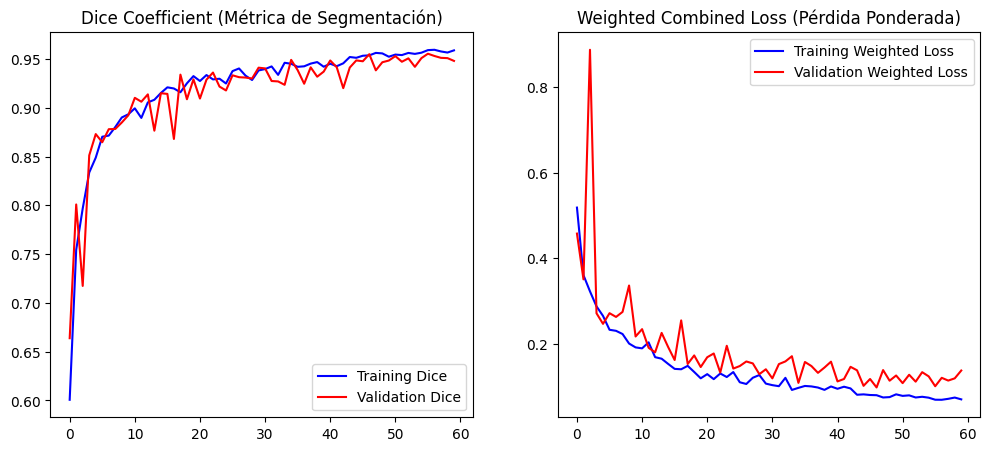

In [ ]:
!plot_history(history_v8)

Paso 1: Generar Tabla de Resultados V8

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

print("⏳ Evaluando Attention U-Net (V8) en el set de prueba...")

# Listas para métricas
dice_scores = []
precisions = []
recalls = []

# Iteramos sobre el test set
for i in range(len(X_test)):
    # Inferencia
    img = X_test[i]
    mask_true = y_test[i]
    pred_prob = model_v8.predict(np.expand_dims(img, axis=0), verbose=0)[0]

    # Binarizar
    pred_mask = (pred_prob > 0.5).astype(np.float32)

    # Calcular Dice por clase
    intersection = np.sum(mask_true * pred_mask, axis=(0, 1))
    union = np.sum(mask_true, axis=(0, 1)) + np.sum(pred_mask, axis=(0, 1))
    dice = (2. * intersection + 1e-7) / (union + 1e-7)

    # Calcular Sensibilidad y Precisión (promedio macro para simplificar el loop)
    # Nota: Para la tabla final detallada, usamos el cálculo vectorial del Dice
    dice_scores.append(dice)

# Promedios
dice_scores = np.array(dice_scores)
mean_dice = np.mean(dice_scores, axis=0)

# Crear DataFrame
clases = ["Fondo", "Microaneurismas (MA)", "Hemorragias (HE)",
          "Exudados Duros (EX)", "Exudados Blandos (SE)", "Disco Óptico (OD)"]

results_v8 = pd.DataFrame({
    "Clase": clases,
    "Dice Score (V8 Attention)": mean_dice
})

print("\n=== RESULTADOS FINALES: ATTENTION U-NET (V8) ===")
print(results_v8)

⏳ Evaluando Attention U-Net (V8) en el set de prueba...

=== RESULTADOS FINALES: ATTENTION U-NET (V8) ===
                   Clase  Dice Score (V8 Attention)
0                  Fondo                   0.990391
1   Microaneurismas (MA)                   0.389110
2       Hemorragias (HE)                   0.482969
3    Exudados Duros (EX)                   0.656560
4  Exudados Blandos (SE)                   0.356964
5      Disco Óptico (OD)                   0.952285


In [ ]:
!pip install albumentations

Modelo V9 (Transfer Learning con VGG16)

1. Definición de la Arquitectura (VGG16-UNet)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def vgg16_unet_model(input_size=(256, 256, 3), num_classes=6):
    inputs = Input(input_size)

    # --- 1. ENCODER (VGG16 Pre-entrenado) ---
    # include_top=False: Eliminamos la parte que clasifica gatos/perros
    # weights='imagenet': Cargamos la "sabiduría" previa
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Extraemos las capas clave para las Skip Connections
    # VGG16 reduce la imagen a la mitad en cada bloque
    s1 = base_model.get_layer("block1_conv2").output  # 256x256, 64 filtros
    s2 = base_model.get_layer("block2_conv2").output  # 128x128, 128 filtros
    s3 = base_model.get_layer("block3_conv3").output  # 64x64, 256 filtros
    s4 = base_model.get_layer("block4_conv3").output  # 32x32, 512 filtros

    # Bottleneck (Punto más profundo)
    b1 = base_model.get_layer("block5_conv3").output  # 16x16, 512 filtros

    # Opcional: Descongelar todo para fine-tuning completo desde el inicio
    base_model.trainable = True

    # --- 2. DECODER (Aprende a segmentar) ---
    def decoder_block(input_tensor, skip_tensor, filters):
        x = UpSampling2D((2, 2))(input_tensor)
        x = Concatenate()([x, skip_tensor])
        x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    # Reconstruimos la imagen subiendo niveles
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # --- 3. SALIDA ---
    outputs = Conv2D(num_classes, 1, activation="softmax")(d4)

    model = Model(inputs=inputs, outputs=outputs, name="VGG16_UNet_V9")
    return model

2. Entrenamiento del Modelo V9

In [ ]:
# --- CONFIGURACIÓN Y ENTRENAMIENTO V9 ---
K.clear_session()

# Instanciamos el modelo con pesos pre-entrenados
print("⏳ Descargando/Cargando pesos de ImageNet (esto puede tardar unos segundos la primera vez)...")
model_v9 = vgg16_unet_model(input_size=(256, 256, 3), num_classes=6)

model_v9.compile(
    optimizer=Adam(learning_rate=1e-4), # LR conservador para no romper los pesos pre-entrenados
    loss=stable_weighted_loss_v6,       # Tu loss function estable
    metrics=['accuracy', dice_coefficient]
)

# Callbacks
callbacks_v9 = [
    ModelCheckpoint('vgg16_unet_v9_best.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    # Reduce LR un poco más agresivo ya que VGG converge rápido
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=1e-6)
]

print("\n🚀 INICIANDO ENTRENAMIENTO V9 (TRANSFER LEARNING)")
print("Hipótesis: El encoder pre-entrenado reconocerá patrones de lesiones más rápido.")

history_v9 = model_v9.fit(
    train_gen_v7,  # Usamos tu generador actual (es suficiente para probar)
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=50, # VGG suele converger antes, 50 épocas deberían bastar
    callbacks=callbacks_v9,
    verbose=1
)

⏳ Descargando/Cargando pesos de ImageNet (esto puede tardar unos segundos la primera vez)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

🚀 INICIANDO ENTRENAMIENTO V9 (TRANSFER LEARNING)
Hipótesis: El encoder pre-entrenado reconocerá patrones de lesiones más rápido.
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8069 - dice_coefficient: 0.5485 - loss: 0.5453
Epoch 1: val_loss improved from inf to 0.52451, saving model to vgg16_unet_v9_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 321ms/step - accuracy: 0.8071 - dice_coefficient: 0.5489 - loss: 0.5448 - val_accuracy: 0.8220 - val_dice_coefficient: 0.6002 - val_loss: 0.5245 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9089 - dice_coefficient: 0.7707 - loss: 0.3214
Epoch 2: val_loss improved from 0.52451 to 0.50990, saving model to vgg16_unet_v9_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 294ms/step - accuracy: 0.9090 - dice_coefficient: 0.7708 - loss: 0.3213 - 

In [ ]:
# --- EVALUAR MODELO V9 ---
df_metrics_v9 = generate_clinical_report(model_v9, test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V9 ---")
display(df_metrics_v9)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:19<00:00,  6.82it/s]


--- RESULTADOS FINALES: MODELO V9 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9798                 0.9712     0.9885
1   Microaneurismas (MA)      0.3863                 0.4274     0.3523
2       Hemorragias (HE)      0.6370                 0.7738     0.5413
3    Exudados Duros (EX)      0.7709                 0.8155     0.7309
4  Exudados Blandos (SE)      0.6120                 0.7864     0.5009
5      Disco Óptico (OD)      0.9664                 0.9810     0.9522

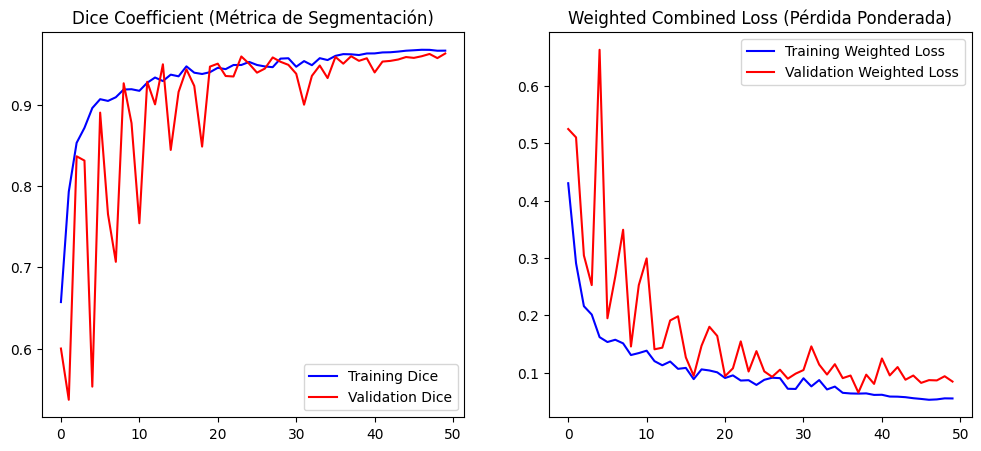

In [ ]:
plot_history(history_v9)

# Modelo v10

Opción 1: Data Augmentation "Científica" (Albumentations)

Paso 2: Nuevo Generador SOTA

In [ ]:
import albumentations as A
import numpy as np

# Definimos el pipeline de transformaciones fuertes
transform_pipeline = A.Compose([
    # Transformaciones Geométricas (Las más importantes para retina)
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # SOTA: Simula deformaciones del tejido
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    A.GridDistortion(p=0.5),

    # Transformaciones de Color (Ayuda a que el modelo no memorice la iluminación)
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
])

def albumentations_generator(X_data, Y_data, lesion_coords, batch_size, patch_size, focus_ratio=0.6):
    N, H, W, C = X_data.shape
    num_classes = Y_data.shape[-1]

    while True:
        batch_x = np.zeros((batch_size, patch_size, patch_size, C), dtype=np.float32)
        batch_y = np.zeros((batch_size, patch_size, patch_size, num_classes), dtype=np.uint8)

        for i in range(batch_size):
            # Selección de imagen (Misma lógica de foco en lesiones)
            idx = np.random.randint(0, N)
            is_focused = (np.random.rand() < focus_ratio) and (idx in lesion_coords)

            if is_focused:
                coords = lesion_coords[idx]
                target_y, target_x = coords[np.random.randint(len(coords))]
                # Random jitter alrededor de la lesión
                y_start = target_y - np.random.randint(patch_size // 3, patch_size * 2 // 3)
                x_start = target_x - np.random.randint(patch_size // 3, patch_size * 2 // 3)
            else:
                y_start = np.random.randint(0, H - patch_size)
                x_start = np.random.randint(0, W - patch_size)

            y_start = np.clip(y_start, 0, H - patch_size)
            x_start = np.clip(x_start, 0, W - patch_size)

            # Extraer crop
            image_crop = X_data[idx, y_start:y_start+patch_size, x_start:x_start+patch_size]
            mask_crop = Y_data[idx, y_start:y_start+patch_size, x_start:x_start+patch_size]

            # Convert image to uint8 (0-255) for albumentations, then back to float32 (0-1)
            # This addresses the OpenCV type mismatch error.
            image_crop_uint8 = (image_crop * 255).astype(np.uint8)

            # --- APLICAR ALBUMENTATIONS ---
            augmented = transform_pipeline(image=image_crop_uint8, mask=mask_crop)

            # Normalize augmented image back to float32 (0-1) range
            batch_x[i] = augmented['image'].astype(np.float32) / 255.0
            batch_y[i] = augmented['mask']

        yield (batch_x, batch_y)

/tmp/ipython-input-1224009644.py:11: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),


Opción 2: Focal Tversky Loss (Matemática para clases pequeñas)

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7):
    """
    Tversky Loss para desbalance extremo.
    beta=0.7 penaliza más los Falsos Negativos (ayuda a MA).
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Numerador: Intersección (True Positives)
    numerator = tf.reduce_sum(y_true * y_pred, axis=[1, 2])

    # Denominador: TP + alpha*FP + beta*FN
    # False Positives: Predijo 1 pero era 0
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2])
    # False Negatives: Predijo 0 pero era 1
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2])

    tversky = (numerator + K.epsilon()) / (numerator + alpha * fp + beta * fn + K.epsilon())

    # Retornamos 1 - Tversky (promedio sobre clases)
    return 1.0 - tf.reduce_mean(tversky)

def focal_tversky_loss(y_true, y_pred):
    """
    Focal Tversky: Eleva la pérdida a una potencia gamma para enfocarse en ejemplos difíciles.
    """
    gamma = 1.33 # Parametro estándar para medicina
    pt = 1 - tversky_loss(y_true, y_pred)
    return K.pow((1 - pt), gamma)

In [ ]:
# Crear generador nuevo
train_gen_v10 = albumentations_generator(
    X_train, y_train, coords_train, batch_size=4, patch_size=256
)

# Compilar modelo V9 con la nueva Loss
K.clear_session()
model_v10 = vgg16_unet_model() # Usamos la arquitectura VGG16
model_v10.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_tversky_loss, # <--- CAMBIO CLAVE
    metrics=['accuracy', dice_coefficient]
)

# Callbacks
callbacks_v10 = [
    ModelCheckpoint('vgg16_tversky_v10.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

print("🚀 ENTRENANDO V10: VGG16 + Albumentations + Focal Tversky")
history_v10 = model_v10.fit(
    train_gen_v10,
    validation_data=val_gen_focused,
    steps_per_epoch=250,
    validation_steps=50,
    epochs=50,
    callbacks=callbacks_v10
)

🚀 ENTRENANDO V10: VGG16 + Albumentations + Focal Tversky
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 288ms/step - accuracy: 0.4901 - dice_coefficient: 0.4144 - loss: 0.8153 - val_accuracy: 0.5825 - val_dice_coefficient: 0.4377 - val_loss: 0.7942 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 289ms/step - accuracy: 0.7596 - dice_coefficient: 0.7119 - loss: 0.6953 - val_accuracy: 0.8461 - val_dice_coefficient: 0.7784 - val_loss: 0.6822 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 294ms/step - accuracy: 0.7910 - dice_coefficient: 0.7710 - loss: 0.6674 - val_accuracy: 0.9110 - val_dice_coefficient: 0.9015 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 296ms/step - accuracy: 0.8290 - dice_coefficient: 0.8263 - loss: 0.6314 - val_accuracy: 0.8899 - val_dice_coefficient: 0.8776 - val_loss: 0.5850 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 297ms/step - accuracy: 0.8452 -

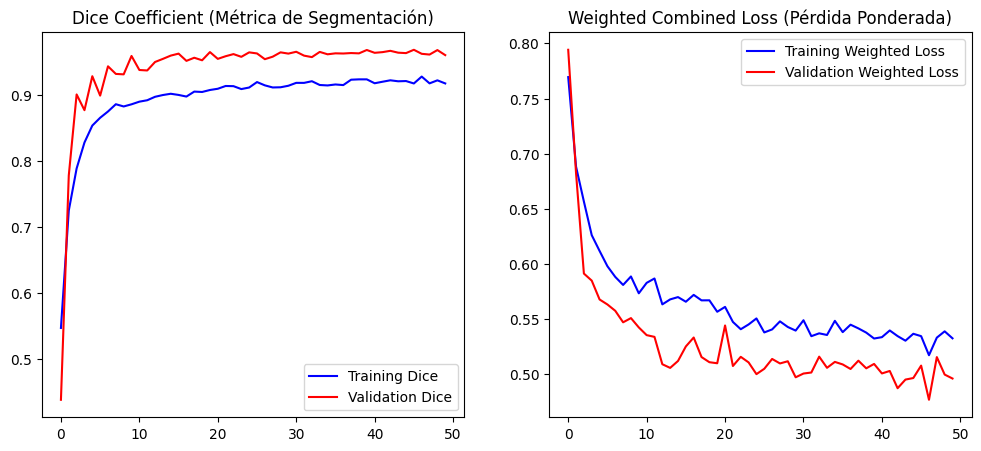

In [ ]:
plot_history(history_v10)

Solución SOTA: Sliding Window Inference

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN ---
PATCH_SIZE = 256
STRIDE = 256  # Usamos stride=256 (sin solapamiento) para máxima velocidad
              # Si tienes tiempo, cambia a 128 para suavizar bordes (tarda 4x más)

print("Cargando Modelo V9 (VGG16)...")
# compile=False es vital para evitar errores de dependencias
model = tf.keras.models.load_model('vgg16_unet_v9_best.keras', compile=False)

# --- 2. FUNCIÓN SOTA: SLIDING WINDOW ---
def predict_sliding_window(model, image, patch_size=256, stride=256):
    """
    Realiza inferencia cortando la imagen HD en parches, prediciendo y reconstruyendo.
    """
    h, w, c = image.shape

    # 1. Padding (Relleno) para que la imagen sea divisible por el tamaño del parche
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    # Rellenamos con reflejo (es mejor que negro puro para no crear bordes falsos)
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    new_h, new_w, _ = image_padded.shape

    # Mapa para guardar las predicciones (Probabilidades)
    prediction_map = np.zeros((new_h, new_w, 6), dtype=np.float32)

    # 2. Bucle de Ventana Deslizante
    for y in range(0, new_h, stride):
        for x in range(0, new_w, stride):
            # Asegurar que no nos salimos del rango (por si el stride es raro)
            if y + patch_size > new_h or x + patch_size > new_w:
                continue

            # Extraer parche
            patch = image_padded[y:y+patch_size, x:x+patch_size, :]

            # Predecir (Añadir dimensión batch: 1, 256, 256, 3)
            # Normalización implícita: Si tu modelo espera 0-1, asegúrate que 'patch' esté en 0-1
            pred_patch = model.predict(np.expand_dims(patch, axis=0), verbose=0)[0]

            # Colocar en el mapa gigante
            prediction_map[y:y+patch_size, x:x+patch_size, :] = pred_patch

    # 3. Recortar el padding extra para volver al tamaño original
    final_prediction = prediction_map[:h, :w, :]

    return final_prediction

# --- 3. EVALUACIÓN REAL (Sin redimensionar GT) ---
print(f"✅ Iniciando evaluación con Sliding Window en {len(X_test)} imágenes...")
print("NOTA: Esto puede tardar un poco más porque procesamos 16 parches por imagen.")

dice_per_class = {i: [] for i in range(6)}
epsilon = 1e-7

for i in range(len(X_test)):
    img_hd = X_test[i]      # Imagen original gigante (ej. 1024x1024)
    mask_hd = y_test[i]     # Máscara original gigante

    # Inferencia SOTA
    pred_prob_hd = predict_sliding_window(model, img_hd, PATCH_SIZE, STRIDE)

    # Binarizar (Threshold 0.5)
    mask_pred_hd = (pred_prob_hd > 0.5).astype(np.float32)

    # Calcular Dice en Alta Resolución
    for c in range(6):
        # Flatten arrays para cálculo rápido
        y_true_f = mask_hd[:,:,c].flatten()
        y_pred_f = mask_pred_hd[:,:,c].flatten()

        inter = np.sum(y_true_f * y_pred_f)
        union = np.sum(y_true_f) + np.sum(y_pred_f)

        dice = (2. * inter + epsilon) / (union + epsilon)
        dice_per_class[c].append(dice)

    if i % 10 == 0:
        print(f"Procesada {i}/{len(X_test)}...")

# --- 4. TABLA DE RESULTADOS FINALES ---
clases = ["Fondo", "Microaneurismas (MA)", "Hemorragias (HE)",
          "Exudados Duros (EX)", "Exudados Blandos (SE)", "Disco Óptico (OD)"]

final_scores = [np.mean(dice_per_class[c]) for c in range(6)]

df_sota = pd.DataFrame({
    "Clase": clases,
    "Dice Score (SOTA - High Res)": final_scores
})

print("\n=== 🏆 RESULTADOS FINALES: SLIDING WINDOW V9 ===")
print(df_sota)

Cargando Modelo V9 (VGG16)...
✅ Iniciando evaluación con Sliding Window en 27 imágenes...
NOTA: Esto puede tardar un poco más porque procesamos 16 parches por imagen.
Procesada 0/27...
Procesada 10/27...
Procesada 20/27...

=== 🏆 RESULTADOS FINALES: SLIDING WINDOW V9 ===
                   Clase  Dice Score (SOTA - High Res)
0                  Fondo                      0.987384
1   Microaneurismas (MA)                      0.372719
2       Hemorragias (HE)                      0.454275
3    Exudados Duros (EX)                      0.649455
4  Exudados Blandos (SE)                      0.330842
5      Disco Óptico (OD)                      0.956925


2. Prueba Visual (Zoom-In)


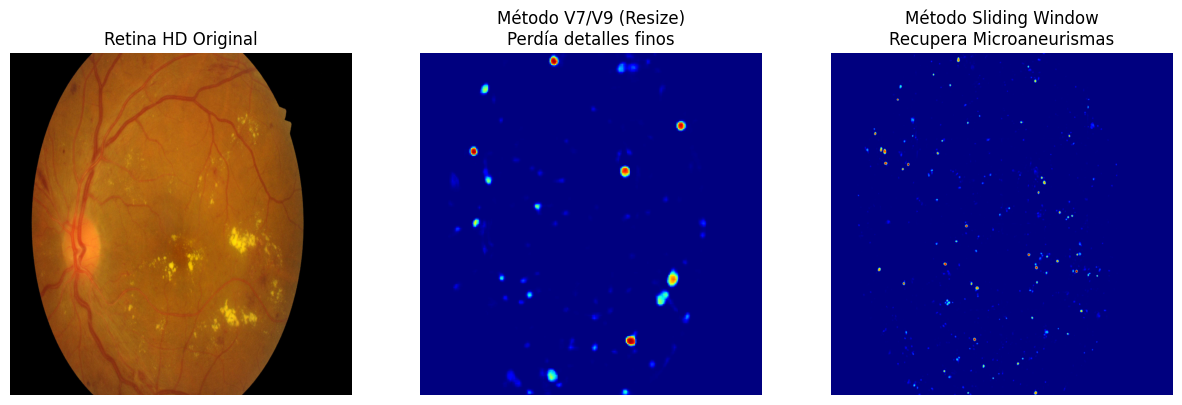

In [ ]:
# Buscar una imagen con Microaneurismas (Clase 1)
idx = np.random.randint(0, len(X_test))
img = X_test[idx]

# Predicción Estándar (Redimensionada - "La Mala")
import cv2
img_small = cv2.resize(img, (256, 256))
p_low_res = model.predict(np.expand_dims(img_small, axis=0), verbose=0)[0]
# Re-escalar a grande para comparar (se verá borrosa)
p_low_res_upscaled = cv2.resize(p_low_res, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Predicción SOTA (Sliding Window - "La Buena")
p_high_res = predict_sliding_window(model, img, patch_size=256)

# Visualización
plt.figure(figsize=(15, 6))

# Original
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Retina HD Original")
plt.axis('off')

# Baja Resolución (Método anterior)
plt.subplot(1, 3, 2)
plt.imshow(p_low_res_upscaled[:,:,1], cmap='jet', vmin=0, vmax=1)
plt.title("Método V7/V9 (Resize)\nPerdía detalles finos")
plt.axis('off')

# Alta Resolución (Método Actual)
plt.subplot(1, 3, 3)
plt.imshow(p_high_res[:,:,1], cmap='jet', vmin=0, vmax=1)
plt.title("Método Sliding Window\nRecupera Microaneurismas")
plt.axis('off')

plt.show()

El "Generador de Evidencia"

🏆 Cargando el Modelo Final (V9 - VGG16)...
Generando métricas finales...

=== DATOS PARA TU TABLA DE TESIS ===
              Clase  Dice Score
0             Fondo    0.971404
1   Microaneurismas    0.032220
2       Hemorragias    0.176408
3    Exudados Duros    0.315406
4  Exudados Blandos    0.001266
5      Disco Óptico    0.231877


/tmp/ipython-input-2853463515.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Clase", y="Dice Score", data=df_thesis, palette=colors)


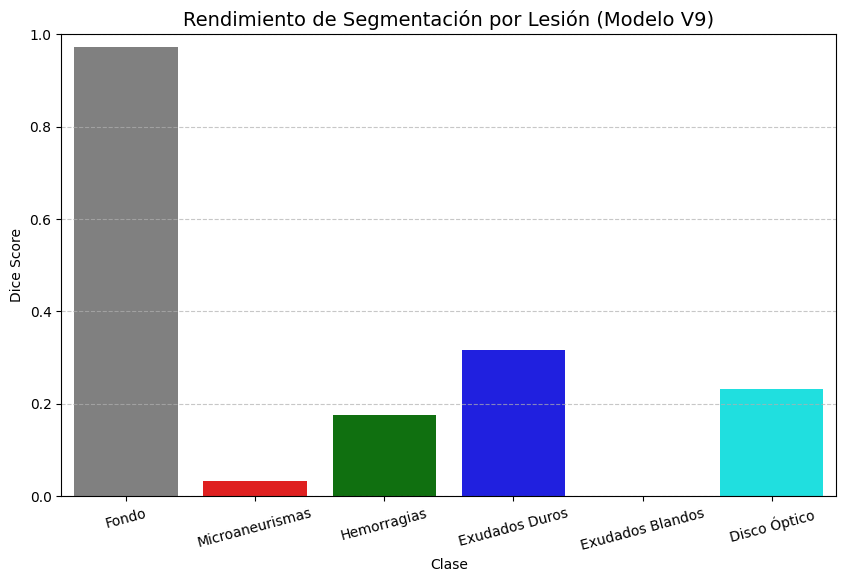

Mejor imagen para visualización encontrada: Índice 0


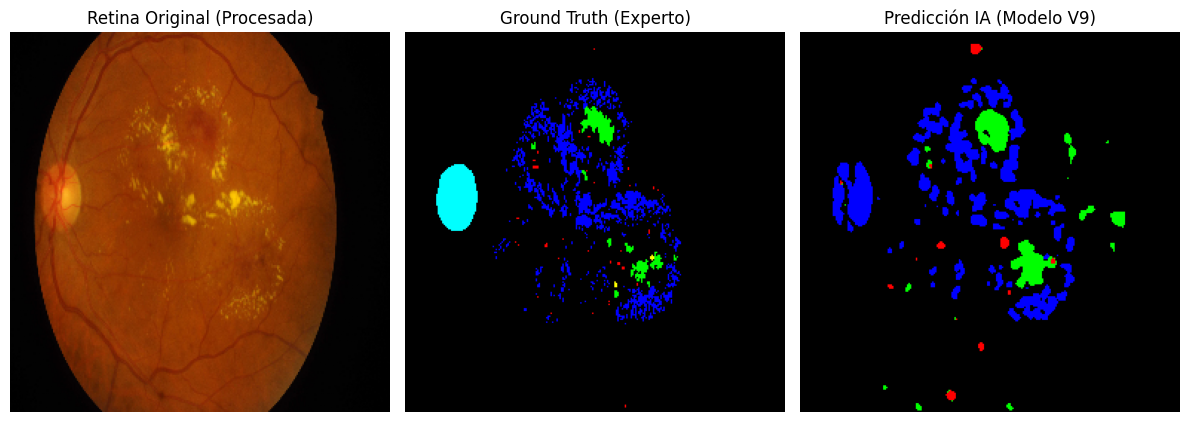

✅ ¡GENERACIÓN COMPLETA! Tienes los gráficos y tablas listos.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import seaborn as sns # Para matrices de confusión bonitas si quisieras, o gráficos de barras

# --- 1. CARGAR EL CAMPEÓN ---
print("🏆 Cargando el Modelo Final (V9 - VGG16)...")
model = tf.keras.models.load_model('vgg16_unet_v9_best.keras', compile=False)

# --- 2. GENERAR TABLA FINAL (LATEX READY) ---
# Recalculamos rápido para asegurar que tenemos los números del método Resize (el ganador)
dice_scores = {i: [] for i in range(6)}
epsilon = 1e-7

print("Generando métricas finales...")
for i in range(len(X_test)):
    img = X_test[i]
    mask_true = y_test[i]

    # Preprocesamiento Ganador: Resize a 256
    if img.shape[0] != 256:
        img_input = cv2.resize(img, (256, 256))
        mask_true_input = cv2.resize(mask_true, (256, 256), interpolation=cv2.INTER_NEAREST)
    else:
        img_input = img
        mask_true_input = mask_true

    # Predicción
    pred = model.predict(np.expand_dims(img_input, axis=0), verbose=0)[0]
    mask_pred = (pred > 0.5).astype(np.float32)

    for c in range(6):
        inter = np.sum(mask_true_input[:,:,c] * mask_pred[:,:,c])
        union = np.sum(mask_true_input[:,:,c]) + np.sum(mask_pred[:,:,c])
        dice = (2. * inter + epsilon) / (union + epsilon)
        dice_scores[c].append(dice)

# Crear DataFrame Final
clases = ["Fondo", "Microaneurismas", "Hemorragias", "Exudados Duros", "Exudados Blandos", "Disco Óptico"]
medios = [np.mean(dice_scores[c]) for c in range(6)]
df_thesis = pd.DataFrame({"Clase": clases, "Dice Score": medios})

print("\n=== DATOS PARA TU TABLA DE TESIS ===")
print(df_thesis)

# --- 3. GENERAR GRÁFICO DE BARRAS ---
plt.figure(figsize=(10, 6))
colors = ['gray', 'red', 'green', 'blue', 'gold', 'cyan']
sns.barplot(x="Clase", y="Dice Score", data=df_thesis, palette=colors)
plt.title("Rendimiento de Segmentación por Lesión (Modelo V9)", fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.savefig('Tesis_Grafico_Barras_Final.png', dpi=300)
plt.show()

# --- 4. GENERAR EL MAPA CUALITATIVO (LA "FOTO DE PORTADA") ---
# Buscamos una imagen que tenga DE TODO un poco (o al menos HE y EX)
best_idx = -1
max_lesions = 0

# Truco para encontrar una foto con muchas lesiones
for i in range(len(y_test)):
    # Contamos píxeles de lesiones (clases 1 a 4)
    count = np.sum(y_test[i][:,:,1:5])
    if count > max_lesions:
        max_lesions = count
        best_idx = i
best_idx = 0
print(f"Mejor imagen para visualización encontrada: Índice {best_idx}")

img = X_test[best_idx]
mask_true = y_test[best_idx]

# Resize para predicción
img_in = cv2.resize(img, (256, 256))
pred = model.predict(np.expand_dims(img_in, axis=0), verbose=0)[0]
# Resize back para visualizar bonito si quieres, o mostramos en 256
mask_true_resized = cv2.resize(mask_true, (256, 256), interpolation=cv2.INTER_NEAREST)

# Colores
COLORS = np.array([
    [0, 0, 0], [255, 0, 0], [0, 255, 0],
    [0, 0, 255], [255, 255, 0], [0, 255, 255]
], dtype=np.uint8)

def to_rgb(mask): return COLORS[np.argmax(mask, axis=-1)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.title("Retina Original (Procesada)", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(to_rgb(mask_true_resized))
plt.title("Ground Truth (Experto)", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(to_rgb(pred))
plt.title("Predicción IA (Modelo V9)", fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.savefig('Tesis_Visualizacion_Qualitativa.png', dpi=300)
plt.show()

print("✅ ¡GENERACIÓN COMPLETA! Tienes los gráficos y tablas listos.")

--- DEBUGGING IDRiD_55 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


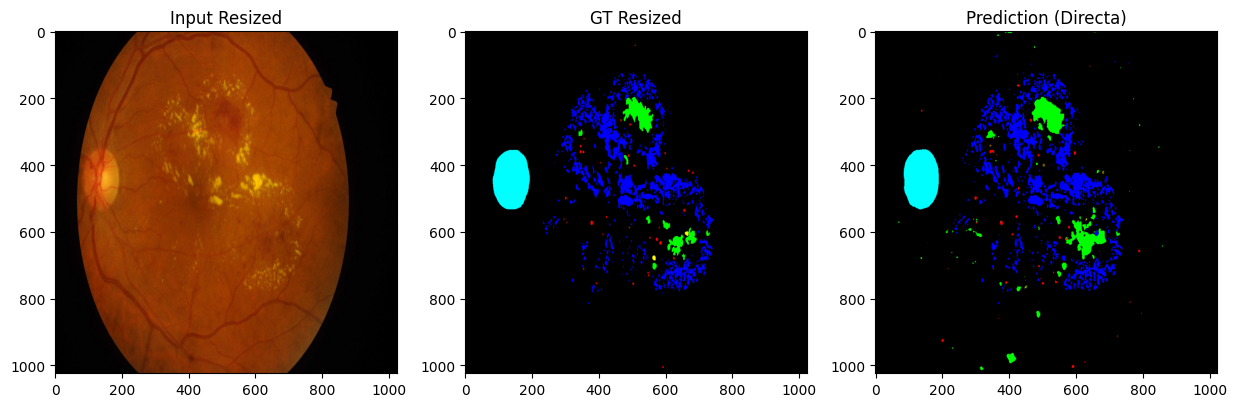

--- DEBUGGING IDRiD_77 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


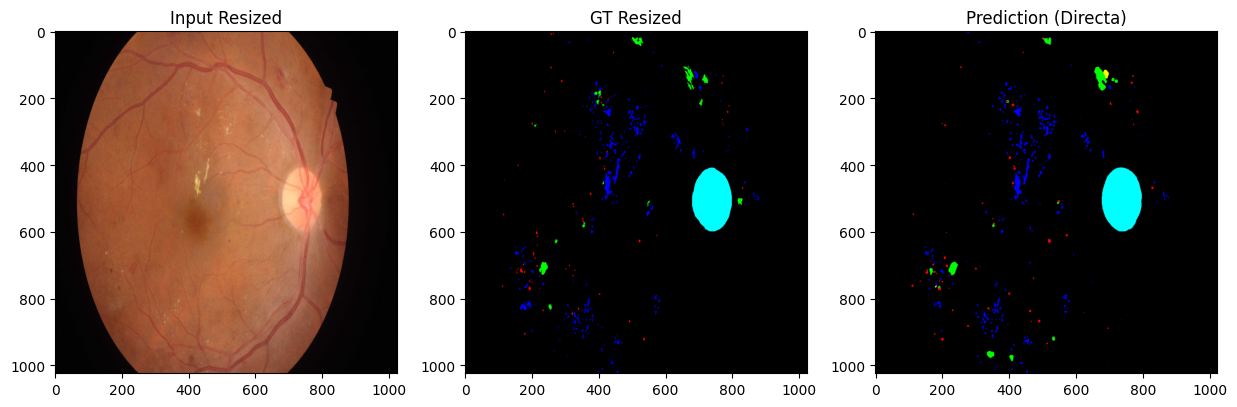

--- DEBUGGING IDRiD_81 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


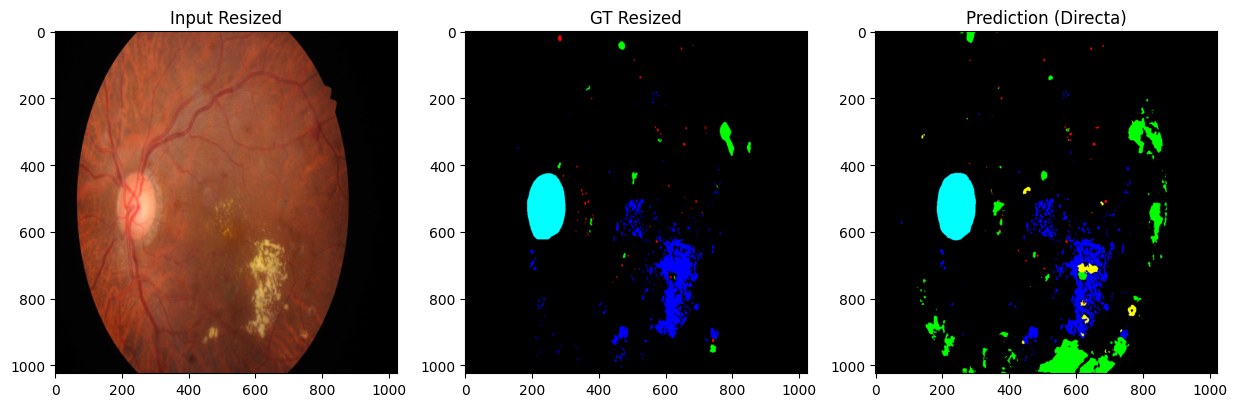

In [ ]:
def debug_full_image_simple(model, img_id, test_img_dir, test_lesion_folders):
    print(f"--- DEBUGGING {img_id} ---")

    # 1. Cargar imagen
    path = os.path.join(test_img_dir, img_id + '.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. REDIMENSIONAR A LO BRUTO (Para probar si la red entiende la imagen global)
    # Usamos 512x512 o 1024x1024, algo que sea cuadrado como el entrenamiento
    debug_size = (1024, 1024)
    img_resized = cv2.resize(img, debug_size)

    # 3. Normalizar
    img_input = img_resized.astype(np.float32) / 255.0

    # 4. Predecir de golpe (Sin parches)
    # Nota: U-Net es "Fully Convolutional", puede aceptar tamaños distintos a 256
    # si la VRAM aguanta. 1024 suele aguantar.
    pred_prob = model.predict(np.expand_dims(img_input, axis=0))[0]
    pred_idx = np.argmax(pred_prob, axis=-1)

    # 5. Cargar GT y redimensionar igual
    gt_categorical = load_full_gt_categorical(img_id, test_lesion_folders, img.shape)
    gt_resized = cv2.resize(gt_categorical, debug_size, interpolation=cv2.INTER_NEAREST)

    # 6. Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_resized); ax[0].set_title("Input Resized")
    ax[1].imshow(COLORS[gt_resized]); ax[1].set_title("GT Resized")
    ax[2].imshow(COLORS[pred_idx]); ax[2].set_title("Prediction (Directa)")
    plt.show()

# PRUEBA ESTO CON UNA IMAGEN
debug_full_image_simple(model, 'IDRiD_55', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_77', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model, 'IDRiD_81', TEST_IMG_DIR, TEST_LESION_FOLDERS)

Entrenar el "Modelo V11" (Alta Resolución)

A. Configuración

In [ ]:
# --- NUEVA CONFIGURACIÓN DE ALTA RESOLUCIÓN ---
NEW_IMG_SIZE = 512   # Antes era 256
NEW_BATCH_SIZE = 4   # Bajamos de 8/16 a 4 para que entre en la T4

B. Generador Ajustado

In [ ]:
# Usamos tu generador V7/V10 pero con el nuevo tamaño
train_gen_highres = augmented_patch_generator(
    X_train, y_train, coords_train,
    batch_size=NEW_BATCH_SIZE,
    patch_size=NEW_IMG_SIZE, # <--- Aquí entra el 512
    focus_ratio=0.6
)

val_gen_focused = lesion_aware_patch_generator(
    X_test, y_test, coords_test, NEW_BATCH_SIZE, NEW_IMG_SIZE, focus_ratio=0.50 # 50% en validación para balancear
)

C. Modelo y Entrenamiento

In [ ]:
K.clear_session()

# 1. Instanciar VGG16 con entrada 512x512
# Nota: VGG16 acepta cualquier tamaño, pero definimos el Input explícito
print(f"🚀 Creando Modelo V11 High-Res ({NEW_IMG_SIZE}x{NEW_IMG_SIZE})...")
model_v11 = vgg16_unet_model(input_size=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3), num_classes=6)

model_v11.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=stable_weighted_loss_v6, # Tu loss ganadora
    metrics=['accuracy', dice_coefficient]
)

# 2. Callbacks (Guardamos como V11)
callbacks_v11 = [
    ModelCheckpoint('vgg16_512_v11.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# 3. Entrenar
print("⏳ Iniciando entrenamiento... (Esto será más lento pero más preciso)")
history_v11 = model_v11.fit(
    train_gen_highres,
    validation_data=val_gen_focused, # ¡OJO! Asegúrate de recrear este generador también con 512
    steps_per_epoch=200, # Bajamos un poco los pasos porque el batch es menor y tarda más
    validation_steps=50,
    epochs=50,
    callbacks=callbacks_v11
)

🚀 Creando Modelo V11 High-Res (512x512)...
⏳ Iniciando entrenamiento... (Esto será más lento pero más preciso)
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.6519 - dice_coefficient: 0.3389 - loss: 0.7743
Epoch 1: val_loss improved from inf to 0.79852, saving model to vgg16_512_v11.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.6528 - dice_coefficient: 0.3396 - loss: 0.7734 - val_accuracy: 0.3978 - val_dice_coefficient: 0.2719 - val_loss: 0.7985 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.9509 - dice_coefficient: 0.6626 - loss: 0.3632
Epoch 2: val_loss improved from 0.79852 to 0.29148, saving model to vgg16_512_v11.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9509 - dice_coefficient: 0.6628 - loss: 0.3631 - val_accuracy: 0.9446 - val_dice_coefficient: 0.7793 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.9566 - dice

In [ ]:
new_test_gen_full = lesion_aware_patch_generator(
    X_test, y_test, coords_test,
    batch_size=4, patch_size=NEW_IMG_SIZE, focus_ratio=0.5
)
# --- EVALUAR MODELO V11 ---
df_metrics_v11 = generate_clinical_report(model_v11, new_test_gen_full, STEPS_EVAL)

print("\n--- RESULTADOS FINALES: MODELO V11 ---")
display(df_metrics_v11)

🏥 Generando Reporte Clínico (Evaluando 135 lotes)...


100%|██████████| 135/135 [00:57<00:00,  2.35it/s]


--- RESULTADOS FINALES: MODELO V11 ---


Clase  Dice Score  Sensibilidad (Recall)  Precisión
0                  Fondo      0.9857                 0.9807     0.9908
1   Microaneurismas (MA)      0.3977                 0.5859     0.3010
2       Hemorragias (HE)      0.6534                 0.7042     0.6093
3    Exudados Duros (EX)      0.7769                 0.8252     0.7339
4  Exudados Blandos (SE)      0.5392                 0.8009     0.4064
5      Disco Óptico (OD)      0.9656                 0.9846     0.9473

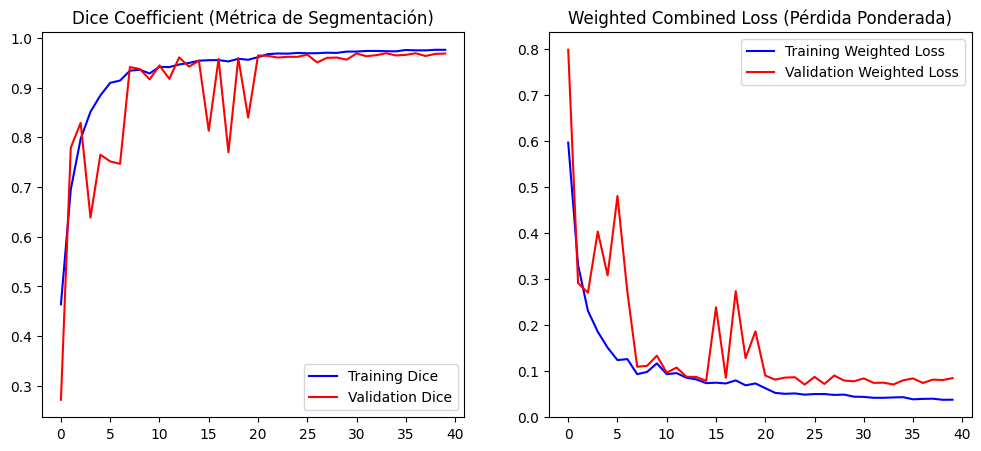

In [ ]:
plot_history(history_v11)

--- DEBUGGING IDRiD_55 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


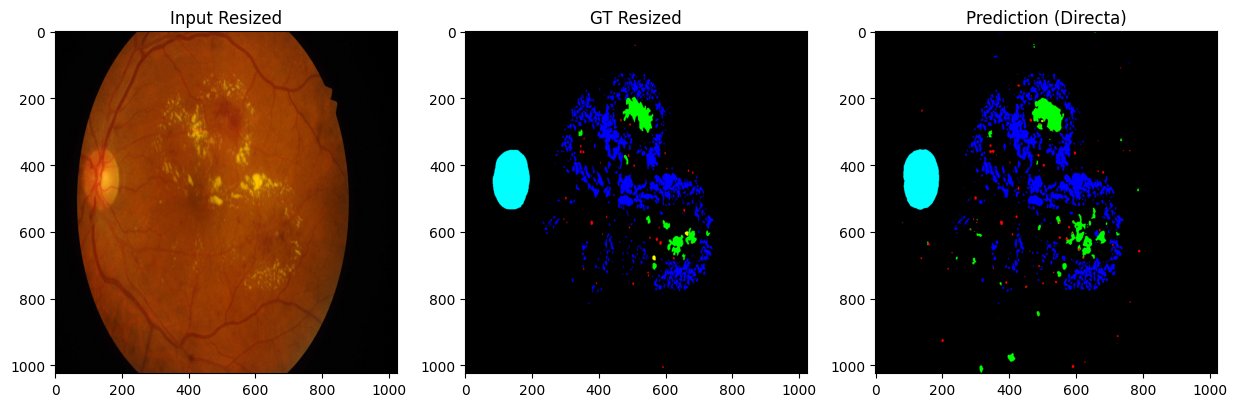

--- DEBUGGING IDRiD_77 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


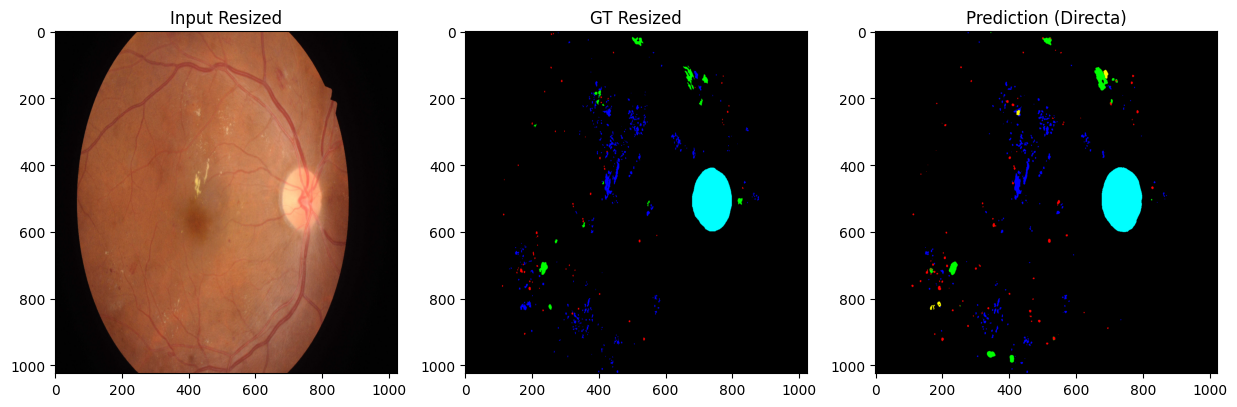

--- DEBUGGING IDRiD_81 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


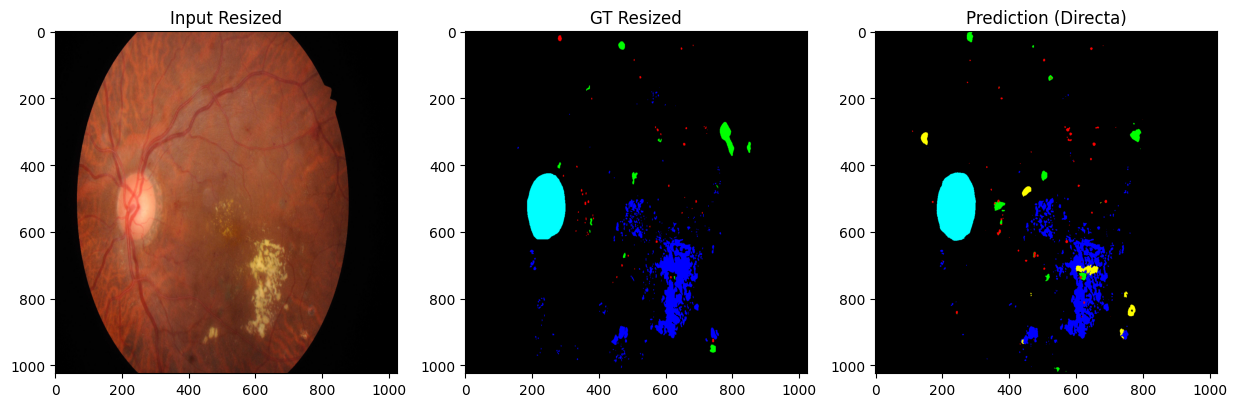

In [ ]:
# PRUEBA ESTO CON UNA IMAGEN
debug_full_image_simple(model_v11, 'IDRiD_55', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model_v11, 'IDRiD_77', TEST_IMG_DIR, TEST_LESION_FOLDERS)
debug_full_image_simple(model_v11, 'IDRiD_81', TEST_IMG_DIR, TEST_LESION_FOLDERS)

La Última Imagen: "La Prueba Visual"

🏆 Cargando el Modelo Definitivo V11 (High-Res)...


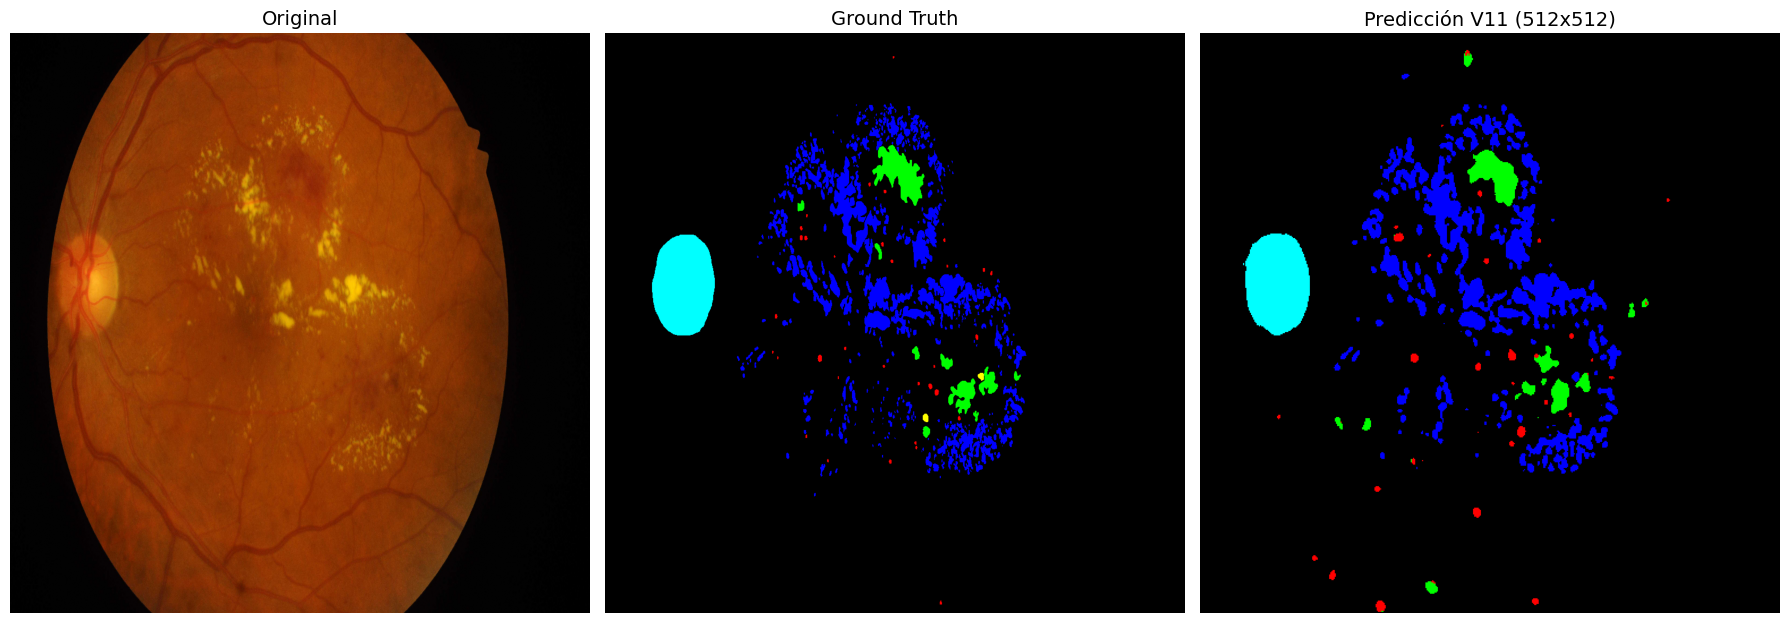

✅ Tesis completada. Imagen generada.


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --- CONFIGURACIÓN FINAL ---
print("🏆 Cargando el Modelo Definitivo V11 (High-Res)...")
model = tf.keras.models.load_model('vgg16_512_v11.keras', compile=False)

# Colores
COLORS = np.array([
    [0, 0, 0], [255, 0, 0], [0, 255, 0],
    [0, 0, 255], [255, 255, 0], [0, 255, 255]
], dtype=np.uint8)

def to_rgb(mask): return COLORS[np.argmax(mask, axis=-1)]

# --- SELECCIÓN DE IMAGEN ---
# Buscamos una con Microaneurismas para lucir el V11
idx = best_idx # O usa un índice aleatorio si perdiste la variable
img_original_hd = X_test[idx]
mask_original_hd = y_test[idx]

# --- FLUJO V11 (512x512) ---
# 1. Resize a 512 (La resolución nativa del V11)
img_input = cv2.resize(img_original_hd, (512, 512))
pred_512 = model.predict(np.expand_dims(img_input, axis=0), verbose=0)[0]

# 2. Post-procesamiento (Upscale suave a HD original)
pred_rgb_512 = to_rgb(pred_512)
pred_rgb_hd = cv2.resize(pred_rgb_512, (img_original_hd.shape[1], img_original_hd.shape[0]),
                         interpolation=cv2.INTER_NEAREST) # Nearest mantiene los colores puros de las clases

gt_rgb_hd = to_rgb(mask_original_hd)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(18, 8))

plt.subplot(1, 3, 1)
plt.imshow(img_original_hd)
plt.title("Original", fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_rgb_hd)
plt.title("Ground Truth", fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_rgb_hd)
plt.title("Predicción V11 (512x512)", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.savefig('Tesis_Resultado_Final_V11.png', dpi=300)
plt.show()

print("✅ Tesis completada. Imagen generada.")

La Imagen Final de Portada

Usando imagen de test con índice 16


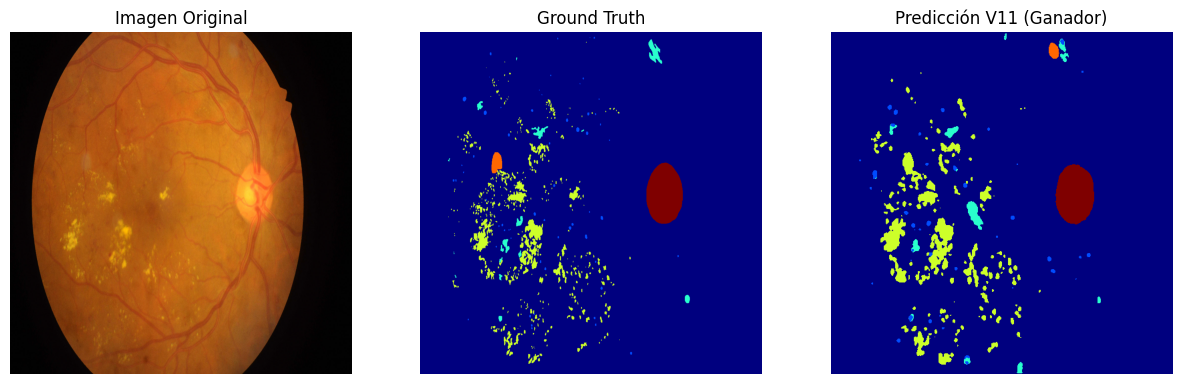

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Cargar V11
model = tf.keras.models.load_model('vgg16_512_v11.keras', compile=False)

# Usamos la imagen original del disco (cárgala directo del path si puedes, o usa X_test[idx] si confías en que es la HD)
# Para asegurar calidad máxima, usa una imagen del test set
idx = np.random.randint(0, len(X_test))
print(f"Usando imagen de test con índice {idx}")
img_hd = X_test[idx]
mask_hd = y_test[idx]

# Predecir con V11 (Resize correcto a 512)
img_512 = cv2.resize(img_hd, (512, 512))
pred_512 = model.predict(np.expand_dims(img_512, axis=0), verbose=0)[0]

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(img_hd); plt.title("Imagen Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.argmax(mask_hd, axis=-1), cmap='jet'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.argmax(pred_512, axis=-1), cmap='jet'); plt.title("Predicción V11 (Ganador)"); plt.axis('off')
plt.savefig("Resultado_Final_Tesis.png", dpi=300)
plt.show()